In [283]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import sys
import matplotlib
import os
import datetime

# 设置中文字体和LaTeX支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'FangSong']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['text.usetex'] = False  # 使用matplotlib的数学文本渲染，而不是完整LaTeX
plt.rcParams['figure.dpi'] = 500
# 也可以启用完整LaTeX支持（需要系统安装LaTeX）
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'


In [284]:
# ========== 参数定义 ==========
# 原始参数（单位：t）
G_c_prime = 1.3  # 集中载荷(驾驶舱)
G_q_prime = 1.0  # 传动系统重量
q_y_prime = 0.135  # 均布重量（取中间值0.12~0.15）
K = 1.1  # 冲击系数
Phi = 1.2  # 动力系数(A5)
Q_max = 45  # 最大起吊重量
l = 22.5  # 跨度(m)
q_w_prime = 0.6  # 梁身自重(t/m)
G_x = 16  # 小车重量(t)
t1 = 1.77  # 前轮距重心(m)
t2 = 1.83  # 后轮距重心(m)
l_c = 2.8  # 操纵室距离左支点(m)
g = 9.81  # 重力加速度(m/s^2)
# 默认加筋系数，easy难度
lambda_reinforce = 1.2

# 腹板厚度 δ_f (根据起重量选择)
if Q_max < 45:  # Q_max = ? < 45t
    delta_f_selected = 7  # 取7mm
else:
    delta_f_selected = 9  # 取9mm


In [285]:

# ========== 冲击矫正计算 ==========
G_q = K * G_q_prime  # 矫正后的传动系统重量
G_c = K * G_c_prime  # 矫正后的驾驶舱重量
q_prime = q_y_prime + q_w_prime  # 总的均布载荷
q = K * q_prime  # 矫正后的均布载荷
limit = l - t1 -  t2  # 最大起吊位置限制
# 车轮压力R计算
R = (G_x / 2) + Phi * (Q_max / 2)  # 单根梁上的车轮压力


In [286]:

# ========== 分段函数定义 ==========
def calculate_components(x):
    # 小车产生的剪力（小车重心在x+t1处）
    Q_R = R * (l - t1 - x) / l
    M_R = R * (l - t1 - x) * x / l
    
    # 初始化各分量
    Q_q = 0
    M_q = 0
    Q_G_q = 0
    M_G_q = 0
    Q_G_c = 0
    M_G_c = 0
    
    # 分段计算（x是截面位置，也是小车位置）
    if 0 <= x < l_c:
        # 均布载荷分量
        Q_q = q * l / 2 - q * x
        M_q = q * l * x / 2 - q * x**2 / 2
        
        # 传动系统重量分量
        Q_G_q = G_q / 2
        M_G_q = G_q * x / 2
        
        # 驾驶舱重量分量
        Q_G_c = G_c * (l - l_c) / l
        M_G_c = G_c * (l - l_c) * x / l
        
    elif l_c <= x < l/2:
        # 均布载荷分量
        Q_q = q * l / 2 - q * x
        M_q = q * l * x / 2 - q * x**2 / 2
        
        # 传动系统重量分量
        Q_G_q = G_q / 2
        M_G_q = G_q * x / 2
        
        # 驾驶舱重量分量
        Q_G_c = -G_c * l_c / l
        M_G_c = G_c * l_c * (l - x) / l
        
    elif l/2 <= x <= l:
        # 均布载荷分量
        Q_q = q * l / 2 - q * x
        M_q = q * l * x / 2 - q * x**2 / 2
        
        # 传动系统重量分量
        Q_G_q = -G_q / 2
        M_G_q = G_q * (l - x) / 2
        
        # 驾驶舱重量分量
        Q_G_c = -G_c * l_c / l
        M_G_c = G_c * l_c * (l - x) / l
    
    # 总剪力和总弯矩
    Q_total = Q_q + Q_G_q + Q_G_c + Q_R
    M_total = M_q + M_G_q + M_G_c + M_R
    
    return Q_total, M_total, Q_q, M_q, Q_G_q, M_G_q, Q_G_c, M_G_c, Q_R, M_R



基本参数
结构跨度 l                    = 22.5 m
最大起吊重量 Q_max              = 45 t
小车重量 G_x                  = 16 t
冲击系数 K                    = 1.1
动力系数 Φ                    = 1.2

载荷参数
原始均布载荷 q'_y               = 0.135 t/m材料重量
梁身自重 q'_w                 = 0.6 t/m
原始驾驶舱重量 G'_c              = 1.3 t
原始传动系统重量 G'_q             = 1.0 t

冲击矫正后载荷
总均布载荷 q                   = 0.808 t/mK×(q'_y+q'_w)
驾驶舱重量 G_c                 = 1.43 tK×G'_c
传动系统重量 G_q                = 1.10 tK×G'_q
车轮压力 R                    = 35.00 tG_x/2 + Φ×Q_max/2

几何参数
驾驶舱位置 l_c                 = 2.80 m距左支点
跨中位置 l/2                  = 11.25 m
前轮距重心 t1                  = 1.77 m
后轮距重心 t2                  = 1.83 m
小车极限位置                    = 18.9 mx=l-t1-t2 (22.5-1.77-1.83)

关键位置内力分析

左支座 (x=0.00m):
  总剪力 Q           =   43.14 t
  总弯矩 M           =    0.00 t·m

驾驶舱位置 (x=2.80m):
  总剪力 Q           =   35.09 t
  总弯矩 M           =  105.52 t·m

跨中位置 (x=11.26m):
  总剪力 Q           =   14.01 t
  总弯矩 M           =  225.23 t·m

小车极限位置 (x=18.90m):
  

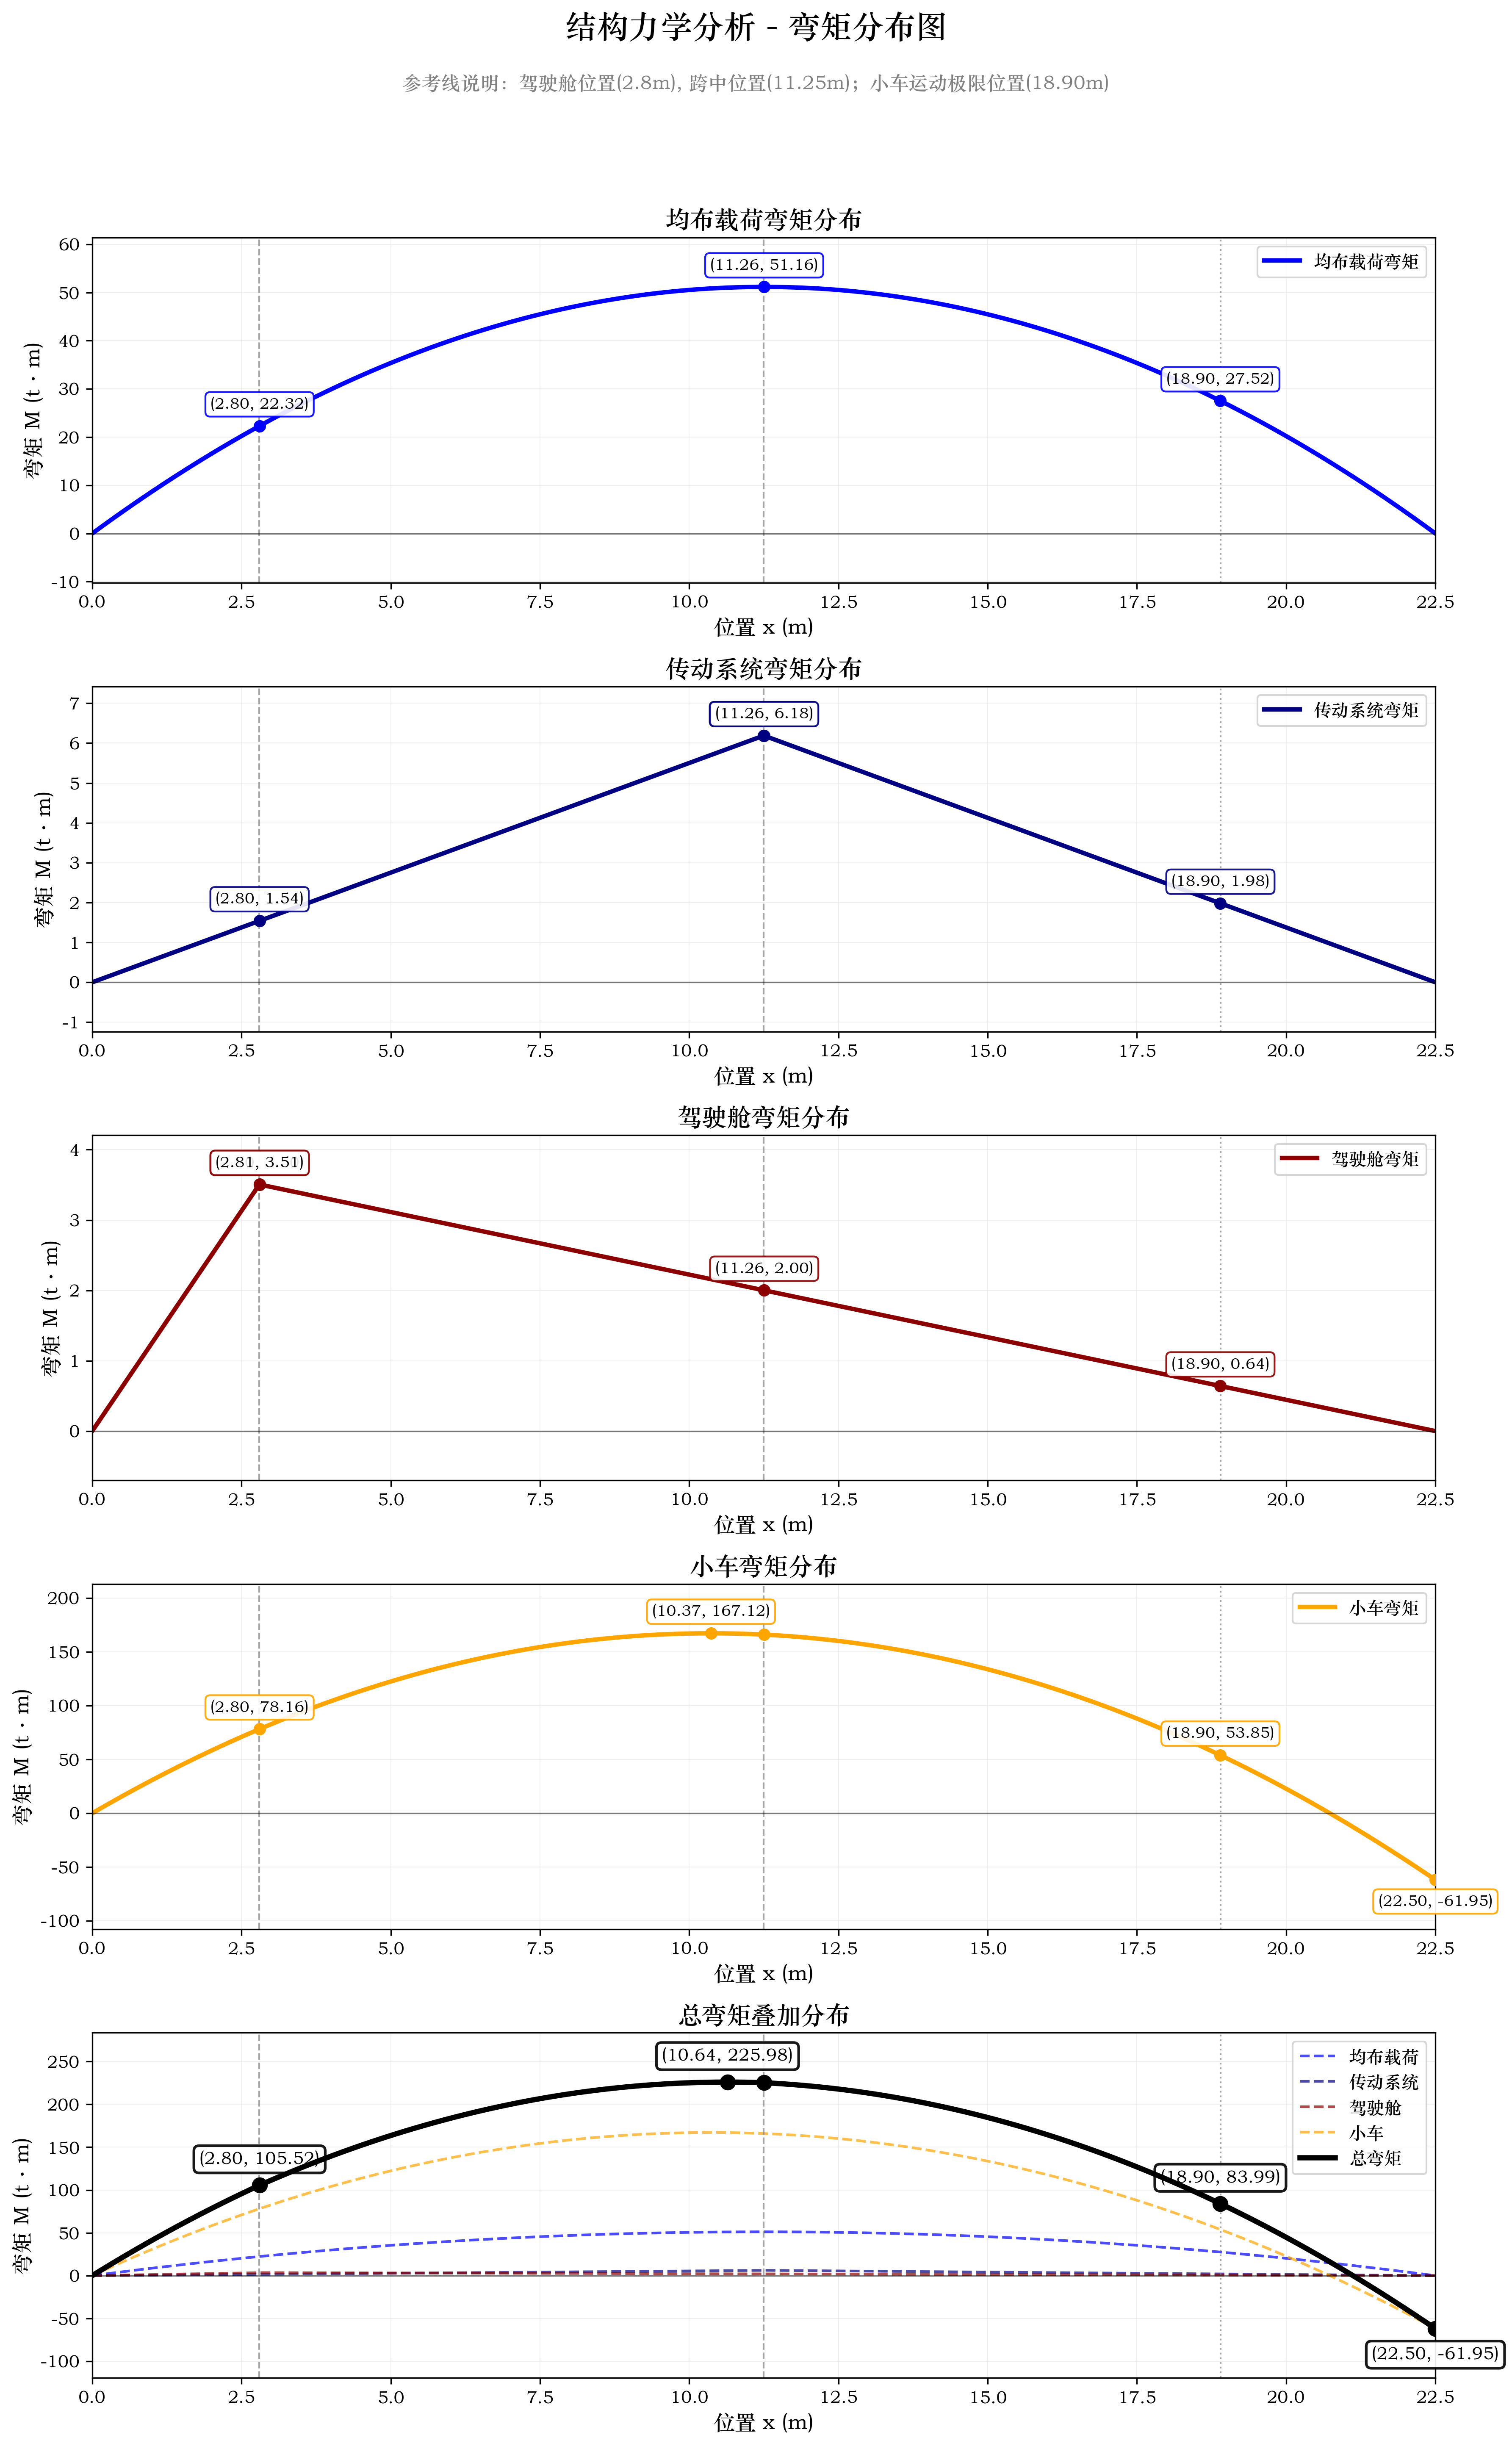

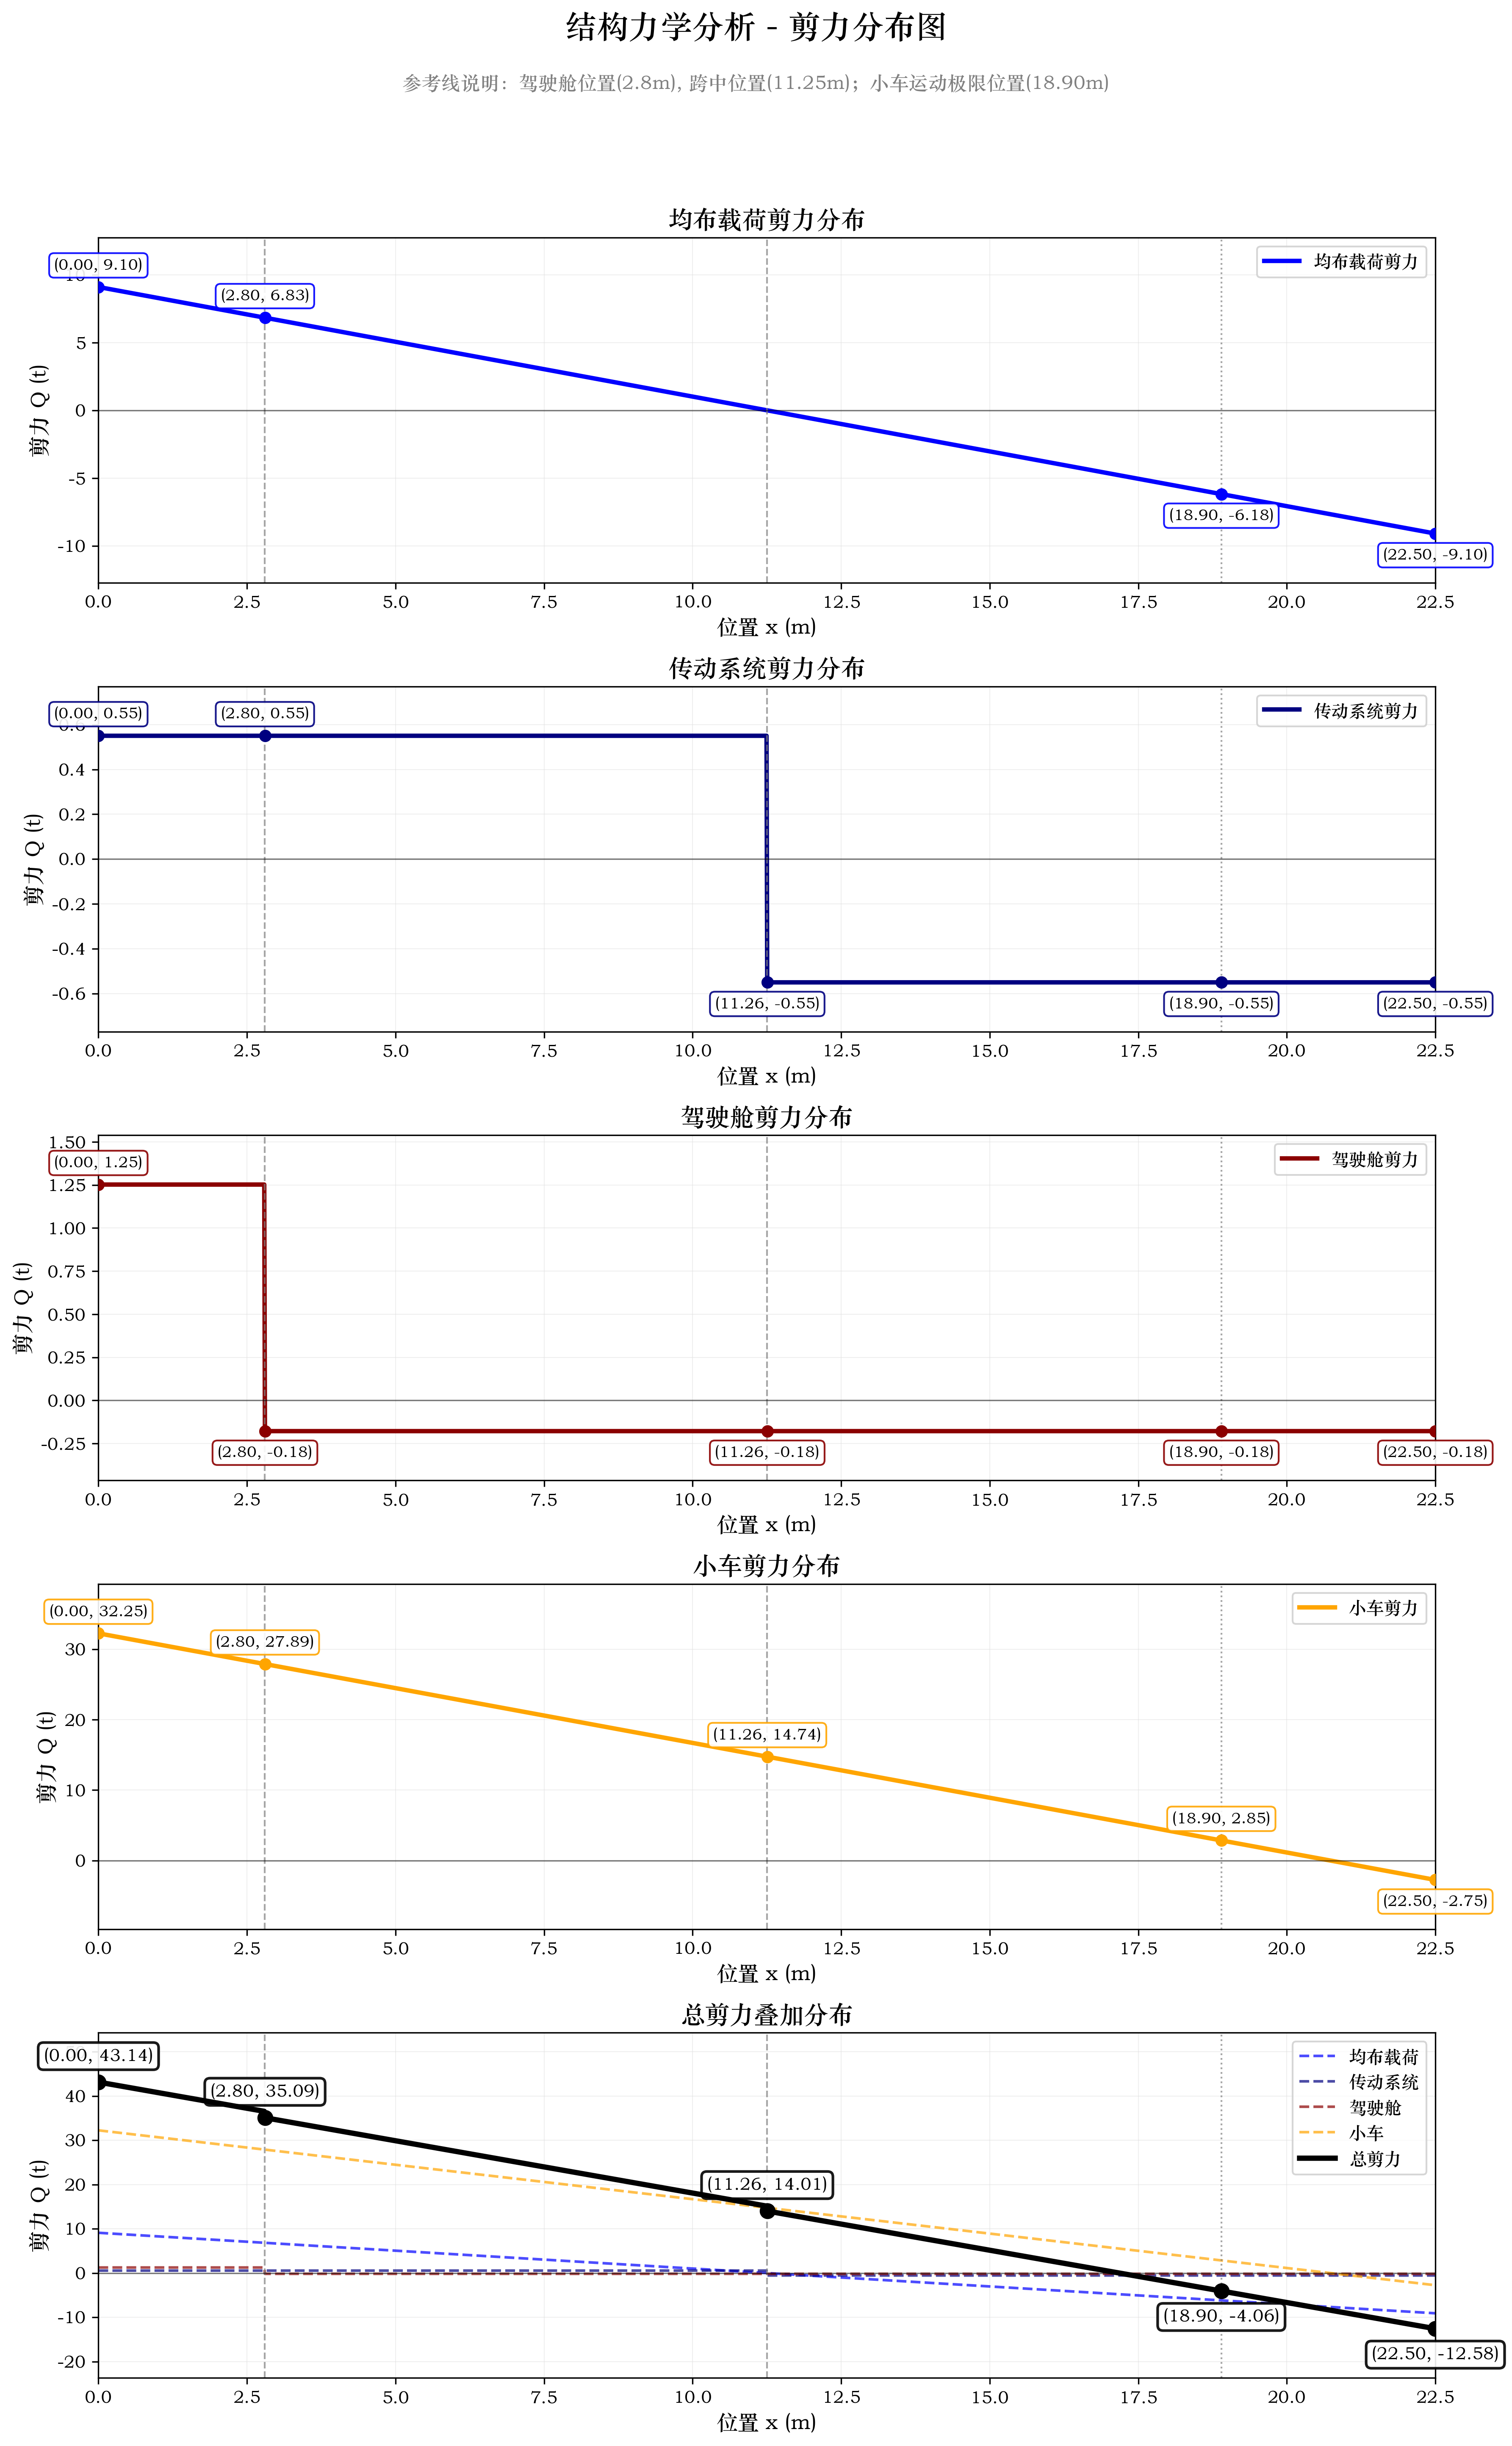

<Figure size 960x720 with 0 Axes>

In [287]:
# ========== 生成数据 ==========
x_points = np.linspace(0, l, 2000)

# 存储各分量数据
Q_total_list = []
M_total_list = []
Q_q_list = []
M_q_list = []
Q_G_q_list = []
M_G_q_list = []
Q_G_c_list = []
M_G_c_list = []
Q_R_list = []
M_R_list = []

for x in x_points:
    Q_total, M_total, Q_q, M_q, Q_G_q, M_G_q, Q_G_c, M_G_c, Q_R, M_R = calculate_components(x)
    Q_total_list.append(Q_total)
    M_total_list.append(M_total)
    Q_q_list.append(Q_q)
    M_q_list.append(M_q)
    Q_G_q_list.append(Q_G_q)
    M_G_q_list.append(M_G_q)
    Q_G_c_list.append(Q_G_c)
    M_G_c_list.append(M_G_c)
    Q_R_list.append(Q_R)
    M_R_list.append(M_R)

# ========== 转换为numpy数组便于计算 ==========
x_points = np.array(x_points)
Q_total_list = np.array(Q_total_list)
M_total_list = np.array(M_total_list)
Q_q_list = np.array(Q_q_list)
M_q_list = np.array(M_q_list)
Q_G_q_list = np.array(Q_G_q_list)
M_G_q_list = np.array(M_G_q_list)
Q_G_c_list = np.array(Q_G_c_list)
M_G_c_list = np.array(M_G_c_list)
Q_R_list = np.array(Q_R_list)
M_R_list = np.array(M_R_list)
# ========== 参数输出与极值分析 ==========
def print_section_header(title):
    """打印章节标题"""
    print("\n" + "=" * 60)
    print(f"{title}")
    print("=" * 60)

def print_parameter(name, value, unit="", explanation=""):
    """统一格式打印参数"""
    if explanation:
        print(f"{name:25} = {value}{unit}  ({explanation})")
    else:
        print(f"{name:25} = {value}{unit}")

# 1. 基本参数输出
print_section_header("基本参数")
print_parameter("结构跨度 l", f"{l} m")
print_parameter("最大起吊重量 Q_max", f"{Q_max} t")
print_parameter("小车重量 G_x", f"{G_x} t")
print_parameter("冲击系数 K", f"{K}")
print_parameter("动力系数 Φ", f"{Phi}")

print_section_header("载荷参数")
print_parameter("原始均布载荷 q'_y", f"{q_y_prime} t/m", "材料重量")
print_parameter("梁身自重 q'_w", f"{q_w_prime} t/m")
print_parameter("原始驾驶舱重量 G'_c", f"{G_c_prime} t")
print_parameter("原始传动系统重量 G'_q", f"{G_q_prime} t")

print_section_header("冲击矫正后载荷")
print_parameter("总均布载荷 q", f"{q:.3f} t/m", f"K×(q'_y+q'_w)")
print_parameter("驾驶舱重量 G_c", f"{G_c:.2f} t", f"K×G'_c")
print_parameter("传动系统重量 G_q", f"{G_q:.2f} t", f"K×G'_q")
print_parameter("车轮压力 R", f"{R:.2f} t", f"G_x/2 + Φ×Q_max/2")

print_section_header("几何参数")
print_parameter("驾驶舱位置 l_c", f"{l_c:.2f} m", "距左支点")
print_parameter("跨中位置 l/2", f"{l/2:.2f} m")
print_parameter("前轮距重心 t1", f"{t1:.2f} m")
print_parameter("后轮距重心 t2", f"{t2:.2f} m")
print_parameter("小车极限位置", f"{l-t1-t2:.1f} m", f"x=l-t1-t2 ({l}-{t1}-{t2})")

# 2. 改进的极值点分析函数（合并到图表代码中）
def find_extreme_points(x_array, y_array, tolerance=0.001):
    """精确查找极值点和转折点"""
    extreme_points = []
    n = len(x_array)
    
    # 添加端点
    extreme_points.append((x_array[0], y_array[0]))
    extreme_points.append((x_array[-1], y_array[-1]))
    
    # 计算一阶差分
    dy = np.diff(y_array) / np.diff(x_array)
    
    # 寻找一阶导数变号点（极值点）
    for i in range(1, len(dy)):
        if dy[i-1] * dy[i] < 0:  # 导数变号
            # 使用三点二次插值精确定位极值点
            x1, x2, x3 = x_array[i-1], x_array[i], x_array[i+1]
            y1, y2, y3 = y_array[i-1], y_array[i], y_array[i+1]
            
            # 抛物线拟合
            denom = (x1-x2)*(x1-x3)*(x2-x3)
            A = (x3*(y2-y1) + x2*(y1-y3) + x1*(y3-y2)) / denom
            B = (x3*x3*(y1-y2) + x2*x2*(y3-y1) + x1*x1*(y2-y3)) / denom
            C = (x2*x3*(x2-x3)*y1 + x3*x1*(x3-x1)*y2 + x1*x2*(x1-x2)*y3) / denom
            
            if abs(A) > tolerance:
                x_extreme = -B/(2*A)
                y_extreme = A*x_extreme*x_extreme + B*x_extreme + C
                
                if x_extreme >= 0 and x_extreme <= l:
                    extreme_points.append((x_extreme, y_extreme))
    
    # 添加已知的关键位置
    critical_x = [l_c, l/2, l-t1-t2]
    for x in critical_x:
        idx = np.argmin(np.abs(x_array - x))
        if 0 <= idx < n:
            extreme_points.append((x_array[idx], y_array[idx]))
    
    # 去重和排序
    extreme_points = sorted(set([(round(x, 3), round(y, 3)) 
                                for (x, y) in extreme_points]), 
                           key=lambda p: p[0])
    
    return extreme_points

# 3. 关键点内力分析（使用已计算的数据）
print_section_header("关键位置内力分析")

# 定义关键位置
critical_positions = [
    (0, "左支座"),
    (l_c, "驾驶舱位置"),
    (l/2, "跨中位置"),
    (l-t1-t2, "小车极限位置"),
    (l, "右支座")
]

for x, desc in critical_positions:
    # 在已计算的数据中查找最近的点
    idx = np.argmin(np.abs(x_points - x))
    if idx < len(x_points):
        print(f"\n{desc} (x={x_points[idx]:.2f}m):")
        print(f"  {'总剪力 Q':15} = {Q_total_list[idx]:>7.2f} t")
        print(f"  {'总弯矩 M':15} = {M_total_list[idx]:>7.2f} t·m")

# 4. 极值点分析（使用已计算的数据）
print_section_header("极值点分析")

# 总剪力极值
Q_extreme_points = find_extreme_points(x_points, Q_total_list)
if Q_extreme_points:
    Q_max_point = max(Q_extreme_points, key=lambda p: abs(p[1]))
    Q_min_point = min(Q_extreme_points, key=lambda p: p[1])
    
    print(f"\n总剪力:")
    print(f"  {'最大剪力位置':20} x = {Q_max_point[0]:>6.2f} m, Q_max = {Q_max_point[1]:>7.2f} t")
    print(f"  {'最小剪力位置':20} x = {Q_min_point[0]:>6.2f} m, Q_min = {Q_min_point[1]:>7.2f} t")

# 总弯矩极值
M_extreme_points = find_extreme_points(x_points, M_total_list)
if M_extreme_points:
    M_max_point = max(M_extreme_points, key=lambda p: p[1])
    
    print(f"\n总弯矩:")
    print(f"  {'最大弯矩位置':20} x = {M_max_point[0]:>6.2f} m, M_max = {M_max_point[1]:>7.2f} t·m")

# 5. 支座反力计算
print_section_header("支座反力计算")

# 左支座反力（固定荷载部分）
R_A_fixed = (q * l / 2) + (G_q / 2) + (G_c * (l - l_c) / l)
print(f"\n固定荷载左支座反力:")
print(f"  R_A_fixed = q·l/2 + G_q/2 + G_c·(l-l_c)/l")
print(f"            = {q:.3f}×{l}/2 + {G_q:.2f}/2 + {G_c:.2f}×({l}-{l_c})/{l}")
print(f"            = {R_A_fixed:.2f} t")

print(f"\n小车荷载引起的附加反力:")
print(f"  ΔR_A = R·(l-t1-x)/l  (x为小车位置)")

# ========== 图表绘制 ==========
# 注意：这里使用的是程序段1中已计算好的数据，所以不再重复计算

# ========== 定义颜色方案 ==========
colors = {
    'total': 'black',
    'q': 'blue',
    'G_q': 'navy',
    'G_c': 'darkred',
    'R': 'orange',
    'grid': '#E0E0E0',
    'ref_line': '#808080'
}

# ========== 设置字体和样式 ==========
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = ['STZhongsong', 'Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# ========== 计算坐标轴扩展函数 ==========
def expand_limits(data, expand_factor=0.15):
    """根据数据计算扩展后的坐标轴范围"""
    data_min = np.min(data)
    data_max = np.max(data)
    data_range = data_max - data_min
    
    if data_range == 0:  # 如果数据没有变化
        if data_min == 0:
            return -0.5, 0.5
        else:
            return data_min * 0.9, data_min * 1.1
    
    # 计算扩展后的范围
    lower_limit = data_min - expand_factor * data_range
    upper_limit = data_max + expand_factor * data_range
    
    return lower_limit, upper_limit

# ========== 绘制各分量单独图表 ==========
# 第一张图：剪力分布（5行1列）
fig_q, axes_q = plt.subplots(5, 1, figsize=(12, 20), dpi=300)

# 第二张图：弯矩分布（5行1列）
fig_m, axes_m = plt.subplots(5, 1, figsize=(12, 20), dpi=300)
# 各分量数据列表
components = [
    (Q_q_list, M_q_list, '均布载荷', colors['q']),
    (Q_G_q_list, M_G_q_list, '传动系统', colors['G_q']),
    (Q_G_c_list, M_G_c_list, '驾驶舱', colors['G_c']),
    (Q_R_list, M_R_list, '小车', colors['R'])
]

# 绘制各分量图表
for i, (Q_data, M_data, name, color) in enumerate(components):
    # 剪力分量图
    ax_q = axes_q[i]
    ax_q.plot(x_points, Q_data, color=color, linewidth=2.5, label=f'{name}剪力')
    
    # 找出关键点
    key_points = find_extreme_points(x_points, Q_data)
    
    # 标记关键点
    for x_val, y_val in key_points:
        if abs(y_val) > 0.01:  # 只标记非零的关键点
            ax_q.plot(x_val, y_val, 'o', color=color, markersize=6, zorder=5)
            # 添加坐标标注，根据y值正负选择标注位置
            va = 'bottom' if y_val >= 0 else 'top'
            offset = 8 if y_val >= 0 else -8
            
            # 创建标注文本
            ax_q.annotate(f'({x_val:.2f}, {y_val:.2f})',
                         xy=(x_val, y_val),
                         xytext=(0, offset),
                         textcoords='offset points',
                         ha='center',
                         va=va,
                         fontsize=9,
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                  alpha=0.9, edgecolor=color, linewidth=1))
    
    # 添加参考线
    ax_q.axvline(x=l_c, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
    ax_q.axvline(x=l/2, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
    ax_q.axvline(x=limit, color=colors['ref_line'], linewidth=1, linestyle=':', alpha=0.7)
    
    ax_q.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)
    ax_q.set_xlabel('位置 x (m)', fontsize=12, fontweight='bold')
    ax_q.set_ylabel('剪力 Q (t)', fontsize=12, fontweight='bold')
    ax_q.set_title(f'{name}剪力分布', fontsize=14, fontweight='bold')
    ax_q.grid(True, color=colors['grid'], linewidth=0.5, alpha=0.5)
    ax_q.set_xlim(0, l)
    ax_q.set_ylim(expand_limits(Q_data, expand_factor=0.2))
    ax_q.legend(loc='best', fontsize=10)
    ax_q.set_facecolor('white')
    
    # 弯矩分量图
    ax_m = axes_m[i]
    ax_m.plot(x_points, M_data, color=color, linewidth=2.5, label=f'{name}弯矩')
    
    # 找出关键点
    key_points = find_extreme_points(x_points, M_data)
    
    # 标记关键点
    for x_val, y_val in key_points:
        if abs(y_val) > 0.01:  # 只标记非零的关键点
            # 对于小车弯矩分布，不显示跨中位置的标注
            if name == '小车' and abs(x_val - l/2) < 0.1:
                # 只画点，不标注坐标
                ax_m.plot(x_val, y_val, 'o', color=color, markersize=6, zorder=5)
            else:
                ax_m.plot(x_val, y_val, 'o', color=color, markersize=6, zorder=5)
                # 添加坐标标注，根据y值正负选择标注位置
                va = 'bottom' if y_val >= 0 else 'top'
                offset = 8 if y_val >= 0 else -8
                
                # 创建标注文本
                ax_m.annotate(f'({x_val:.2f}, {y_val:.2f})',
                             xy=(x_val, y_val),
                             xytext=(0, offset),
                             textcoords='offset points',
                             ha='center',
                             va=va,
                             fontsize=9,
                             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                      alpha=0.9, edgecolor=color, linewidth=1))
    
    # 添加参考线
    ax_m.axvline(x=l_c, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
    ax_m.axvline(x=l/2, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
    ax_m.axvline(x=limit, color=colors['ref_line'], linewidth=1, linestyle=':', alpha=0.7)
    
    ax_m.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)
    ax_m.set_xlabel('位置 x (m)', fontsize=12, fontweight='bold')
    ax_m.set_ylabel('弯矩 M (t·m)', fontsize=12, fontweight='bold')
    ax_m.set_title(f'{name}弯矩分布', fontsize=14, fontweight='bold')
    ax_m.grid(True, color=colors['grid'], linewidth=0.5, alpha=0.5)
    ax_m.set_xlim(0, l)
    ax_m.set_ylim(expand_limits(M_data, expand_factor=0.2))
    ax_m.legend(loc='best', fontsize=10)
    ax_m.set_facecolor('white')

# ========== 绘制总叠加图 ==========
# 总剪力叠加图
ax_total_q = axes_q[4]
# 绘制各分量（虚线）
ax_total_q.plot(x_points, Q_q_list, color=colors['q'], linewidth=1.5, linestyle='--', alpha=0.7, label='均布载荷')
ax_total_q.plot(x_points, Q_G_q_list, color=colors['G_q'], linewidth=1.5, linestyle='--', alpha=0.7, label='传动系统')
ax_total_q.plot(x_points, Q_G_c_list, color=colors['G_c'], linewidth=1.5, linestyle='--', alpha=0.7, label='驾驶舱')
ax_total_q.plot(x_points, Q_R_list, color=colors['R'], linewidth=1.5, linestyle='--', alpha=0.7, label='小车')
# 绘制总剪力（粗实线）
ax_total_q.plot(x_points, Q_total_list, color=colors['total'], linewidth=3, label='总剪力', zorder=5)

# 使用已经计算好的总剪力极值点
for x_val, y_val in Q_extreme_points:
    if abs(y_val) > 0.01:  # 只标记非零的关键点
        ax_total_q.plot(x_val, y_val, 'o', color=colors['total'], markersize=8, zorder=10)
        # 添加坐标标注，使用与分量子图相同的风格
        va = 'bottom' if y_val >= 0 else 'top'
        offset = 10 if y_val >= 0 else -10
        
        # 创建标注文本
        ax_total_q.annotate(f'({x_val:.2f}, {y_val:.2f})',
                     xy=(x_val, y_val),
                     xytext=(0, offset),
                     textcoords='offset points',
                     ha='center',
                     va=va,
                     fontsize=10,
                     fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                              alpha=0.9, edgecolor=colors['total'], linewidth=1.5))

# 添加参考线
ax_total_q.axvline(x=l_c, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
ax_total_q.axvline(x=l/2, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
ax_total_q.axvline(x=limit, color=colors['ref_line'], linewidth=1, linestyle=':', alpha=0.7)

ax_total_q.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)
ax_total_q.set_xlabel('位置 x (m)', fontsize=12, fontweight='bold')
ax_total_q.set_ylabel('剪力 Q (t)', fontsize=12, fontweight='bold')
ax_total_q.set_title('总剪力叠加分布', fontsize=14, fontweight='bold')
ax_total_q.grid(True, color=colors['grid'], linewidth=0.5, alpha=0.5)
ax_total_q.set_xlim(0, l)
ax_total_q.set_ylim(expand_limits(Q_total_list, expand_factor=0.2))
ax_total_q.legend(loc='best', fontsize=10)
ax_total_q.set_facecolor('white')

# 总弯矩叠加图
ax_total_m = axes_m[4]
# 绘制各分量（虚线）
ax_total_m.plot(x_points, M_q_list, color=colors['q'], linewidth=1.5, linestyle='--', alpha=0.7, label='均布载荷')
ax_total_m.plot(x_points, M_G_q_list, color=colors['G_q'], linewidth=1.5, linestyle='--', alpha=0.7, label='传动系统')
ax_total_m.plot(x_points, M_G_c_list, color=colors['G_c'], linewidth=1.5, linestyle='--', alpha=0.7, label='驾驶舱')
ax_total_m.plot(x_points, M_R_list, color=colors['R'], linewidth=1.5, linestyle='--', alpha=0.7, label='小车')
# 绘制总弯矩（粗实线）
ax_total_m.plot(x_points, M_total_list, color=colors['total'], linewidth=3, label='总弯矩', zorder=5)

# 使用已经计算好的总弯矩极值点
for x_val, y_val in M_extreme_points:
    if abs(y_val) > 0.01:  # 只标记非零的关键点
        # 在总弯矩叠加分布中不显示跨中位置的坐标标注
        if abs(x_val - l/2) < 0.1:
            # 只画点，不标注坐标
            ax_total_m.plot(x_val, y_val, 'o', color=colors['total'], markersize=8, zorder=10)
        else:
            ax_total_m.plot(x_val, y_val, 'o', color=colors['total'], markersize=8, zorder=10)
            # 添加坐标标注，使用与分量子图相同的风格
            va = 'bottom' if y_val >= 0 else 'top'
            offset = 10 if y_val >= 0 else -10
            
            # 创建标注文本
            ax_total_m.annotate(f'({x_val:.2f}, {y_val:.2f})',
                         xy=(x_val, y_val),
                         xytext=(0, offset),
                         textcoords='offset points',
                         ha='center',
                         va=va,
                         fontsize=10,
                         fontweight='bold',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                  alpha=0.9, edgecolor=colors['total'], linewidth=1.5))

# 添加参考线
ax_total_m.axvline(x=l_c, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
ax_total_m.axvline(x=l/2, color=colors['ref_line'], linewidth=1, linestyle='--', alpha=0.7)
ax_total_m.axvline(x=limit, color=colors['ref_line'], linewidth=1, linestyle=':', alpha=0.7)

ax_total_m.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)
ax_total_m.set_xlabel('位置 x (m)', fontsize=12, fontweight='bold')
ax_total_m.set_ylabel('弯矩 M (t·m)', fontsize=12, fontweight='bold')
ax_total_m.set_title('总弯矩叠加分布', fontsize=14, fontweight='bold')
ax_total_m.grid(True, color=colors['grid'], linewidth=0.5, alpha=0.5)
ax_total_m.set_xlim(0, l)
ax_total_m.set_ylim(expand_limits(M_total_list, expand_factor=0.2))
ax_total_m.legend(loc='best', fontsize=10)
ax_total_m.set_facecolor('white')

# ========== 整体调整 ==========
plt.suptitle('结构力学分析 - 剪力与弯矩分量分布及叠加效果', 
             fontsize=18, fontweight='bold', y=0.98)

# 在标题下添加图例说明
#fig.text(0.5, 0.95, 
#         f'参考线说明：驾驶舱位置({l_c}m), 跨中位置({l/2:.2f}m)；小车运动极限位置({l-t1-t2:.2f}m)',
#         ha='center', fontsize=11, style='italic', color=colors['ref_line'])
# 剪力图的标题
fig_q.suptitle('结构力学分析 - 剪力分布图', fontsize=18, fontweight='bold', y=0.98)
fig_q.text(0.5, 0.95, 
         f'参考线说明：驾驶舱位置({l_c}m), 跨中位置({l/2:.2f}m)；小车运动极限位置({l-t1-t2:.2f}m)',
         ha='center', fontsize=11, style='italic', color=colors['ref_line'])
fig_q.tight_layout(rect=[0, 0.02, 1, 0.93])
fig_q.subplots_adjust(hspace=0.3)

# 弯矩图的标题
fig_m.suptitle('结构力学分析 - 弯矩分布图', fontsize=18, fontweight='bold', y=0.98)
fig_m.text(0.5, 0.95, 
         f'参考线说明：驾驶舱位置({l_c}m), 跨中位置({l/2:.2f}m)；小车运动极限位置({l-t1-t2:.2f}m)',
         ha='center', fontsize=11, style='italic', color=colors['ref_line'])
fig_m.tight_layout(rect=[0, 0.02, 1, 0.93])
fig_m.subplots_adjust(hspace=0.3)

# 显示和保存剪力图
plt.figure(fig_q.number)
plt.show()
fig_q.savefig('剪力分布图.png', dpi=500, bbox_inches='tight', facecolor='white')
fig_q.savefig('剪力分布图.pdf', format='png', bbox_inches='tight', facecolor='white')

# 显示和保存弯矩图
plt.figure(fig_m.number)
plt.show()
fig_m.savefig('弯矩分布图.png', dpi=500, bbox_inches='tight', facecolor='white')
fig_m.savefig('弯矩分布图.pdf', format='png', bbox_inches='tight', facecolor='white')
plt.show()

In [288]:
# 许用应力计算
eta = 1.5  # 安全系数
sigma_allow = sigma_s / eta  # 许用应力 (MPa)
tau_allow = sigma_allow / np.sqrt(3)  # 许用剪应力 (MPa)
f_allow = l_mm / 700  # 许用挠度 (mm)

print(f"材料: Q235钢")
print(f"屈服强度 σ_s = {sigma_s} MPa")
print(f"弹性模量 E = {E/1000:.0f} GPa")
print(f"安全系数 η = {eta}")
print(f"许用应力 [σ] = σ_s/η = {sigma_allow:.2f} MPa")
print(f"许用剪应力 [τ] = [σ]/√3 = {tau_allow:.2f} MPa")
print(f"许用挠度 [f] = L/700 = {f_allow:.1f} mm")

# ========== 8.1 根据刚度条件确定梁高 h1 ==========
print("\n" + "-" * 40)
print("1. 根据刚度条件确定梁高 h1")
print("-" * 40)

# 计算 M_p 和 M_q (注意单位转换)
M_p_Nmm = (R_N + G_q_N) * l_mm / 4  # N·mm
M_q_Nmm = q_N_per_mm * l_mm**2 / 8  # N·mm

print(f"M_p = (R + G_q)L/4 = {Nmm_to_tm(M_p_Nmm):.2f} t·m = {M_p_Nmm:.0f} N·mm")
print(f"M_q = qL²/8 = {Nmm_to_tm(M_q_Nmm):.2f} t·m = {M_q_Nmm:.0f} N·mm")

# 刚度条件公式
h1_mm = (sigma_allow * l_mm**2 / (24 * E * M_max_Nmm * f_allow)) * (4 * M_p_Nmm + 5 * M_q_Nmm)
print(f"h1 = [σ]L²/(24EM_max[f]) × (4M_p + 5M_q)")
print(f"  = {sigma_allow:.2f}×{l_mm:.0f}²/(24×{E:.0f}×{M_max_Nmm:.0f}×{f_allow:.1f}) × (4×{M_p_Nmm:.0f} + 5×{M_q_Nmm:.0f})")
print(f"  = {h1_mm:.1f} mm")
print(f"  = {h1_mm/1000:.3f} m")

# ========== 8.2 根据强度条件确定梁高 h2 ==========
print("\n" + "-" * 40)
print("2. 根据强度条件确定梁高 h2")
print("-" * 40)


# 提前确认腹板尺寸
print("\n" + "-" * 40)
print("5. 确定腹板尺寸")
print("-" * 40)

print(f"腹板厚度 δ_f = {delta_f_selected} mm (Q = {Q_max}t < 50t)")



h2_mm = np.sqrt(M_max_Nmm / (delta_f_selected * sigma_allow))
print(f"假设腹板厚度 δ_f = {delta_f} mm")
print(f"h2 = √(M_max/(δ_f[σ]))")
print(f"  = √({M_max_Nmm:.0f}/({delta_f_selected}×{sigma_allow:.2f}))")
print(f"  = {h2_mm:.1f} mm")
print(f"  = {h2_mm/1000:.3f} m")

# ========== 8.3 根据经济性条件确定梁高 h3 ==========
print("\n" + "-" * 40)
print("3. 根据经济性条件确定梁高 h3")
print("-" * 40)

# 注意：M_q和M_p的单位需要转换为kg·cm
# 1 N·mm = 0.101972 kg·mm = 0.0101972 kg·cm
M_p_kg_cm = M_p_Nmm * 0.0101972  # 转换为kg·cm
M_q_kg_cm = M_q_Nmm * 0.0101972  # 转换为kg·cm

# 其他参数也需要转换为合适的单位
delta_f_cm = delta_f_selected / 10  # mm转换为cm
f_allow_cm = f_allow / 10  # mm转换为cm
l_cm = l_mm / 10  # mm转换为cm

# 经济性条件公式
h3_cm = 0.01 * np.cbrt((5 * M_q_kg_cm + 4 * M_p_kg_cm) * l_cm**2 / (48 * delta_f_cm * f_allow_cm))
h3_mm = h3_cm * 10  # cm转换为mm

print(f"M_q = {M_q_kg_cm:.0f} kg·cm, M_p = {M_p_kg_cm:.0f} kg·cm")
print(f"h3 = 0.01 × ∛((5M_q + 4M_p)L²/(48δ_f[f]))")
print(f"  = 0.01 × ∛((5×{M_q_kg_cm:.0f} + 4×{M_p_kg_cm:.0f})×{l_cm:.0f}²/(48×{delta_f_cm:.1f}×{f_allow_cm:.1f}))")
print(f"  = {h3_cm:.2f} cm = {h3_mm:.1f} mm")
print(f"  = {h3_mm/1000:.3f} m")

# ========== 8.4 选择梁高 h ==========
print("\n" + "-" * 40)
print("4. 选择梁高 h")
print("-" * 40)

print(f"刚度条件 h1 = {h1_mm:.1f} mm ({h1_mm/1000:.3f} m)")
print(f"强度条件 h2 = {h2_mm:.1f} mm ({h2_mm/1000:.3f} m)")
print(f"经济条件 h3 = {h3_mm:.1f} mm ({h3_mm/1000:.3f} m)")

# 根据推荐范围选择 h/L = 1/14 ~ 1/18
h_min_recommended = l_mm / 18
h_max_recommended = l_mm / 14

print(f"\n推荐范围: h/L = 1/14 ~ 1/18")
print(f"  h_min = L/18 = {l_mm:.0f}/18 = {h_min_recommended:.1f} mm")
print(f"  h_max = L/14 = {l_mm:.0f}/14 = {h_max_recommended:.1f} mm")

# 选择梁高的逻辑
print(f"\n选择逻辑:")
print(f"1. 如果 h1 > h3 > h2，则选择 h3")
print(f"2. 否则按常规选择")

if h1_mm > h3_mm > h2_mm:
    print(f"条件满足: h1({h1_mm:.1f}) > h3({h3_mm:.1f}) > h2({h2_mm:.1f})")
    h_selected = h3_mm
    print(f"选择经济条件梁高 h = h3 = {h_selected:.1f} mm")
elif h2_mm > h1_mm:
    print(f"条件: h2({h2_mm:.1f}) > h1({h1_mm:.1f})")
    h_selected = h2_mm
    print(f"选择强度条件梁高 h = h2 = {h_selected:.1f} mm")
    # 检查是否相差不大
    diff_percent = abs(h2_mm - h1_mm) / min(h2_mm, h1_mm) * 100
    if diff_percent < 10:  # 相差小于10%认为相差不大
        print(f"h1和h2相差{diff_percent:.1f}%，认为相差不大，选择h1")
        h_selected = h1_mm
        print(f"选择刚度条件梁高 h = h1 = {h_selected:.1f} mm")
else:
    print(f"条件: h1({h1_mm:.1f}) > h2({h2_mm:.1f})")
    h_selected = h1_mm
    print(f"选择刚度条件梁高 h = h1 = {h_selected:.1f} mm")

# 确保在推荐范围内
#h_selected = max(min(h_selected, h_max_recommended), h_min_recommended)

print(f"\n最终选择梁高 h = {h_selected:.1f} mm ({h_selected/1000:.3f} m)")
#print(f"h/L = {h_selected/l_mm:.4f} (在推荐范围 {1/18:.4f} ~ {1/14:.4f} 内)")




材料: Q235钢
屈服强度 σ_s = 235 MPa
弹性模量 E = 210 GPa
安全系数 η = 1.5
许用应力 [σ] = σ_s/η = 156.67 MPa
许用剪应力 [τ] = [σ]/√3 = 90.45 MPa
许用挠度 [f] = L/700 = 32.1 mm

----------------------------------------
1. 根据刚度条件确定梁高 h1
----------------------------------------
M_p = (R + G_q)L/4 = 203.06 t·m = 1992043125 N·mm
M_q = qL²/8 = 51.16 t·m = 501907957 N·mm
h1 = [σ]L²/(24EM_max[f]) × (4M_p + 5M_q)
  = 156.67×22500²/(24×210000×2216821508×32.1) × (4×1992043125 + 5×501907957)
  = 2314.0 mm
  = 2.314 m

----------------------------------------
2. 根据强度条件确定梁高 h2
----------------------------------------

----------------------------------------
5. 确定腹板尺寸
----------------------------------------
腹板厚度 δ_f = 9 mm (Q = 45t < 50t)
假设腹板厚度 δ_f = 8 mm
h2 = √(M_max/(δ_f[σ]))
  = √(2216821508/(9×156.67))
  = 1253.9 mm
  = 1.254 m

----------------------------------------
3. 根据经济性条件确定梁高 h3
----------------------------------------
M_q = 5118056 kg·cm, M_p = 20313262 kg·cm
h3 = 0.01 × ∛((5M_q + 4M_p)L²/(48δ_f[f]))
  = 0.01 × ∛

In [289]:
# ========== 8.5 确定腹板尺寸 ==========
# 腹板高度 h_f (取 0.97~0.98h)
h_f = 0.975 * h_selected
print(f"腹板高度 h_f = 0.975h = 0.975 × {h_selected:.1f} = {h_f:.1f} mm")
# 腹板面积
F_f = 2 * delta_f_selected * h_f  # 两块腹板面积之和
print(f"两块腹板面积之和 F_f = 2δ_f·h_f = 2×{delta_f_selected}×{h_f:.1f} = {F_f:.1f} mm²")

# ========== 8.6 确定盖板尺寸 ==========
print("\n" + "-" * 40)
print("6. 确定盖板尺寸")
print("-" * 40)

# 腹板间距 B0
B0_min = l_mm / 60
B0_max = l_mm / 50
B0_selected = (B0_min + B0_max) / 2
print(f"腹板间距 B0 推荐范围: L/60 ~ L/50 = {l_mm:.0f}/60 ~ {l_mm:.0f}/50")
print(f"  B0_min = {B0_min:.1f} mm, B0_max = {B0_max:.1f} mm")
print(f"选择 B0 = {B0_selected:.1f} mm")

# 盖板宽度 B (自动焊)
B_selected = B0_selected + 2 * (20 + delta_f_selected)
print(f"盖板宽度 B = B0 + 2(20+δ_f) = {B0_selected:.1f} + 2×(20+{delta_f_selected}) = {B_selected:.1f} mm")

# 计算所需惯性矩
I_x_required = (l_mm**2 / (48 * E * f_allow)) * (5 * M_q_Nmm + 4 * M_p_Nmm)
print(f"\n所需惯性矩 I_x = L²/(48E[f]) × (5M_q + 4M_p)")
print(f"  = {l_mm:.0f}²/(48×{E:.0f}×{f_allow:.1f}) × (5×{M_q_Nmm:.0f} + 4×{M_p_Nmm:.0f})")
print(f"  = {I_x_required:.0f} mm⁴")

# 腹板惯性矩
I_xf = (h_f**2 * F_f) / 12
print(f"腹板惯性矩 I_xf = h_f²·F_f/12 = {h_f:.1f}²×{F_f:.1f}/12 = {I_xf:.0f} mm⁴")

# 盖板所需惯性矩
I_xg_required = I_x_required - I_xf
print(f"盖板所需惯性矩 I_xg = I_x - I_xf = {I_x_required:.0f} - {I_xf:.0f} = {I_xg_required:.0f} mm⁴")

# 盖板总面积
F_g_total = 4 * I_xg_required / (h_selected**2)
print(f"两块盖板总面积 F_g_total = 4I_xg/h² = 4×{I_xg_required:.0f}/{h_selected:.1f}² = {F_g_total:.1f} mm²")

# 单块盖板面积
F_g1 = F_g_total / 2
print(f"单块盖板面积 F_g1 = F_g_total/2 = {F_g_total:.1f}/2 = {F_g1:.1f} mm²")

# 盖板厚度
delta_g = F_g1 / B_selected
print(f"盖板厚度 δ_g = F_g1/B = {F_g1:.1f}/{B_selected:.1f} = {delta_g:.2f} mm")

# 检查最小厚度要求
delta_g_min = 6  # Q235最小厚度6mm
if delta_g < delta_g_min:
    print(f"警告: 计算盖板厚度 δ_g = {delta_g:.2f} mm < 最小厚度 {delta_g_min} mm")
    print(f"调整盖板厚度为 δ_g = {delta_g_min} mm")
    delta_g_selected = delta_g_min
else:
    # 向上取整到标准厚度
    delta_g_selected = np.ceil(delta_g)
    print(f"选择盖板厚度 δ_g = {delta_g_selected:.0f} mm")

# 重新计算盖板宽度，保持面积不变
if delta_g < delta_g_min:
    B_required = F_g1 / delta_g_selected
    print(f"需要调整盖板宽度: B = F_g1/δ_g = {F_g1:.1f}/{delta_g_selected} = {B_required:.1f} mm")
    B_selected = np.ceil(B_required)
    print(f"选择盖板宽度 B = {B_selected:.0f} mm")

# ========== 8.7 确定梁端尺寸 ==========
print("\n" + "-" * 40)
print("7. 确定梁端尺寸")
print("-" * 40)

# 梁端高度 h_D
h_D_min = 0.4 * h_selected
h_D_max = 0.6 * h_selected
h_D_selected = (h_D_min + h_D_max) / 2
print(f"梁端高度 h_D 推荐范围: (0.4~0.6)h = {h_D_min:.1f} ~ {h_D_max:.1f} mm")
print(f"选择 h_D = {h_D_selected:.1f} mm")

# 梁端长度 L_D
L_D_min = 0.1 * l_mm
L_D_max = 0.2 * l_mm
L_D_selected = min(max(2000, (L_D_min + L_D_max) / 2), 3000)  # 限制在2-3m
print(f"梁端长度 L_D 推荐范围: (0.1~0.2)L = {L_D_min:.1f} ~ {L_D_max:.1f} mm")
print(f"选择 L_D = {L_D_selected:.1f} mm ({L_D_selected/1000:.2f} m)")

# ========== 8.8 计算截面几何性质 ==========
print("\n" + "-" * 40)
print("8. 计算截面几何性质")
print("-" * 40)

# 实际尺寸汇总
print("截面实际尺寸:")
print(f"  梁高 h = {h_selected:.1f} mm")
print(f"  腹板高度 h_f = {h_f:.1f} mm")
print(f"  腹板厚度 δ_f = {delta_f_selected} mm")
print(f"  盖板宽度 B = {B_selected:.0f} mm")
print(f"  盖板厚度 δ_g = {delta_g_selected:.0f} mm")
print(f"  腹板间距 B0 = {B0_selected:.1f} mm")
print(f"  梁端高度 h_D = {h_D_selected:.1f} mm")
print(f"  梁端长度 L_D = {L_D_selected:.1f} mm")

# 计算实际惯性矩
# I_x = δ_g·B·h²/2 + δ_f·h_f³/6 + 2·B·δ_g·((δ_g + h_f)/2)²
I_x_actual = (delta_g_selected * B_selected * h_selected**2 / 2 + 
              delta_f_selected * h_f**3 / 6 + 
              2 * B_selected * delta_g_selected * ((delta_g_selected + h_f) / 2)**2)

print(f"\n实际惯性矩 I_x = {I_x_actual:.0f} mm⁴")
print(f"所需惯性矩 I_x = {I_x_required:.0f} mm⁴")
print(f"满足要求: {I_x_actual >= I_x_required}")

# 计算Iy
# I_y = δ_f·h_f·(B0+2δ_f)²/2 + δ_g·B0³/6 + 2·δ_f·h_f·((δ_f+B0)/2)²
I_y_actual = (delta_f_selected * h_f * (B0_selected + 2 * delta_f_selected)**2 / 2 + 
              delta_g_selected * B0_selected**3 / 6 + 
              2 * delta_f_selected * h_f * ((delta_f_selected + B0_selected) / 2)**2)

print(f"实际惯性矩 I_y = {I_y_actual:.0f} mm⁴")

# 抗弯截面系数
W_x = I_x_actual / (h_selected / 2)
W_y = I_y_actual / (B_selected / 2)
print(f"抗弯截面系数 W_x = I_x/(h/2) = {W_x:.0f} mm³")
print(f"抗弯截面系数 W_y = I_y/(B/2) = {W_y:.0f} mm³")

# ========== 8.9 强度校核 ==========
print("\n" + "-" * 40)
print("9. 强度校核")
print("-" * 40)

# 8.9.1 最大正应力校核
M_s_max = 0.1 * M_max_Nmm  # 侧向弯矩取最大弯矩的10%
sigma_max = M_max_Nmm / W_x + M_s_max / W_y
print(f"最大弯矩 M_max = {Nmm_to_tm(M_max_Nmm):.2f} t·m = {M_max_Nmm:.0f} N·mm")
print(f"侧向弯矩 M_s_max = 0.1M_max = {Nmm_to_tm(M_s_max):.2f} t·m")
print(f"最大正应力 σ_max = M_max/W_x + M_s_max/W_y")
print(f"  = {M_max_Nmm:.0f}/{W_x:.0f} + {M_s_max:.0f}/{W_y:.0f}")
print(f"  = {sigma_max:.2f} MPa")
print(f"许用应力 [σ] = {sigma_allow:.2f} MPa")
print(f"满足要求: {sigma_max <= sigma_allow} (安全系数: {sigma_allow/sigma_max:.2f})")

# 8.9.2 最大剪应力校核
h_fd = h_f  # 支座处腹板高度
tau_max_avg = Q_max_N / (2 * h_fd * delta_f_selected)
print(f"\n最大剪力 Q_max = {Q_max_N/1000:.1f} kN = {Q_max_N:.0f} N")
print(f"平均剪应力 τ_max_avg = Q_max/(2h_fd·δ_f)")
print(f"  = {Q_max_N:.0f}/(2×{h_fd:.1f}×{delta_f_selected})")
print(f"  = {tau_max_avg:.2f} MPa")
print(f"许用剪应力 [τ] = {tau_allow:.2f} MPa")
print(f"满足要求: {tau_max_avg <= tau_allow} (安全系数: {tau_allow/tau_max_avg:.2f})")

# 8.9.3 变截面处复合应力校核
print(f"\n变截面处 (L_D = {L_D_selected/1000:.2f} m 处) 复合应力校核:")

# 查找变截面处的弯矩和剪力
# 变截面位置 (距离左支座L_D处)
x_LD = L_D_selected / 1000  # 转换为m
# 找到最接近的x点
idx_LD = np.argmin(np.abs(x_points - x_LD))
x_LD_actual = x_points[idx_LD]

# 计算变截面处的弯矩和剪力
Q_b = Q_total_list[idx_LD]
M_b = M_total_list[idx_LD]

# 转换为国际单位
Q_b_N = t_to_N(Q_b)
M_b_Nmm = t_to_N(M_b) * 1000
M_s_b = 0.1 * M_b_Nmm  # 侧向弯矩

print(f"变截面位置: x = {x_LD_actual:.2f} m")
print(f"该处剪力 Q_b = {Q_b:.2f} t = {Q_b_N:.0f} N")
print(f"该处弯矩 M_b = {M_b:.2f} t·m = {Nmm_to_tm(M_b_Nmm):.2f} t·m")

# 变截面处截面特性 (假设线性变化)
h_b = h_D_selected + (h_selected - h_D_selected) * (x_LD_actual / l)
h_fb = 0.975 * h_b
print(f"变截面处梁高 h_b = {h_b:.1f} mm")
print(f"变截面处腹板高 h_fb = {h_fb:.1f} mm")

# 计算变截面处的Wx和Wy
W_xb = I_x_actual / (h_b / 2)  # 近似计算
W_yb = W_y  # 假设宽度不变

sigma_b = M_b_Nmm / W_xb + M_s_b / W_yb
tau_b = Q_b_N / (2 * h_fb * delta_f_selected)
sigma_F = np.sqrt(sigma_b**2 + 3 * tau_b**2)

print(f"弯曲应力 σ_b = M_b/W_xb + M_s_b/W_yb")
print(f"  = {M_b_Nmm:.0f}/{W_xb:.0f} + {M_s_b:.0f}/{W_yb:.0f} = {sigma_b:.2f} MPa")
print(f"剪应力 τ_b = Q_b/(2h_fb·δ_f)")
print(f"  = {Q_b_N:.0f}/(2×{h_fb:.1f}×{delta_f_selected}) = {tau_b:.2f} MPa")
print(f"复合应力 σ_F = √(σ_b² + 3τ_b²)")
print(f"  = √({sigma_b:.2f}² + 3×{tau_b:.2f}²) = {sigma_F:.2f} MPa")
print(f"许用复合应力 1.1[σ] = {1.1 * sigma_allow:.2f} MPa")
print(f"满足要求: {sigma_F <= 1.1 * sigma_allow} (安全系数: {1.1 * sigma_allow/sigma_F:.2f})")

# ========== 8.10 刚度校核 ==========
print("\n" + "-" * 40)
print("10. 刚度校核")
print("-" * 40)

# R' = (G_x + Q)/2 (不考虑动力系数)
R_prime = (G_x + Q_max) / 2  # t
R_prime_N = t_to_N(R_prime)  # N

f_max = (R_prime_N * l_mm**3) / (48 * E * I_x_actual)
print(f"等效集中载荷 R' = (G_x + Q)/2 = ({G_x} + {Q_max})/2 = {R_prime:.1f} t = {R_prime_N:.0f} N")
print(f"最大挠度 f_max = R'L³/(48EI_x)")
print(f"  = {R_prime_N:.0f}×{l_mm:.0f}³/(48×{E:.0f}×{I_x_actual:.0f})")
print(f"  = {f_max:.2f} mm")
print(f"许用挠度 [f] = L/700 = {f_allow:.1f} mm")
print(f"满足要求: {f_max <= f_allow} (安全系数: {f_allow/f_max:.2f})")


腹板高度 h_f = 0.975h = 0.975 × 1573.4 = 1534.1 mm
两块腹板面积之和 F_f = 2δ_f·h_f = 2×9×1534.1 = 27613.7 mm²

----------------------------------------
6. 确定盖板尺寸
----------------------------------------
腹板间距 B0 推荐范围: L/60 ~ L/50 = 22500/60 ~ 22500/50
  B0_min = 375.0 mm, B0_max = 450.0 mm
选择 B0 = 412.5 mm
盖板宽度 B = B0 + 2(20+δ_f) = 412.5 + 2×(20+9) = 470.5 mm

所需惯性矩 I_x = L²/(48E[f]) × (5M_q + 4M_p)
  = 22500²/(48×210000×32.1) × (5×501907957 + 4×1992043125)
  = 16371425446 mm⁴
腹板惯性矩 I_xf = h_f²·F_f/12 = 1534.1²×27613.7/12 = 5415634216 mm⁴
盖板所需惯性矩 I_xg = I_x - I_xf = 16371425446 - 5415634216 = 10955791230 mm⁴
两块盖板总面积 F_g_total = 4I_xg/h² = 4×10955791230/1573.4² = 17701.4 mm²
单块盖板面积 F_g1 = F_g_total/2 = 17701.4/2 = 8850.7 mm²
盖板厚度 δ_g = F_g1/B = 8850.7/470.5 = 18.81 mm
选择盖板厚度 δ_g = 19 mm

----------------------------------------
7. 确定梁端尺寸
----------------------------------------
梁端高度 h_D 推荐范围: (0.4~0.6)h = 629.4 ~ 944.1 mm
选择 h_D = 786.7 mm
梁端长度 L_D 推荐范围: (0.1~0.2)L = 2250.0 ~ 4500.0 mm
选择 L_D = 3000

In [290]:
# ========== 8.11 车轮压力计算与型号选择 ==========
print("\n" + "-" * 40)
print("11. 车轮压力计算与型号选择")
print("-" * 40)

# 已有 R_prime 作为单侧两轮总反力，假定双轮布置，距点 t1,t2
R = R_prime  # t
P1 = R * t2 / (t1 + t2)
P2 = R * t1 / (t1 + t2)
P_need = max(P1, P2)

print("联立方程：")
print("  P1 + P2 = R")
print("  P1·t1 = P2·t2")
print(f"已知 R = {R:.2f} t, t1 = {t1:.2f} m, t2 = {t2:.2f} m")
print(f"解得: P1 = R·t2/(t1+t2) = {P1:.3f} t, P2 = R·t1/(t1+t2) = {P2:.3f} t")
print(f"取较大值 P_need = {P_need:.3f} t 进行选型")

# 车轮表
wheel_table = [
    {"D": 250, "rail": "轻11", "level": "轻", "Pmax": 3.30, "mat": "ZG55"},
    {"D": 250, "rail": "轻11", "level": "中", "Pmax": 2.67, "mat": "ZG55"},
    {"D": 250, "rail": "轻11", "level": "重", "Pmax": 2.38, "mat": "ZG55"},
    {"D": 250, "rail": "轻18", "level": "轻", "Pmax": 4.18, "mat": "ZG55"},
    {"D": 250, "rail": "轻18", "level": "中", "Pmax": 3.49, "mat": "ZG55"},
    {"D": 250, "rail": "轻18", "level": "重", "Pmax": 2.99, "mat": "ZG55"},
    {"D": 350, "rail": "轻24", "level": "轻", "Pmax": 14.1, "mat": "ZG55"},
    {"D": 350, "rail": "轻24", "level": "中", "Pmax": 11.8, "mat": "ZG55"},
    {"D": 350, "rail": "轻24", "level": "重", "Pmax": 10.1, "mat": "ZG55"},
    {"D": 400, "rail": "重38", "level": "轻", "Pmax": 16.0, "mat": "ZG55"},
    {"D": 400, "rail": "重38", "level": "中", "Pmax": 13.4, "mat": "ZG55"},
    {"D": 400, "rail": "重38", "level": "重", "Pmax": 11.4, "mat": "ZG55"},
    {"D": 500, "rail": "重43", "level": "轻", "Pmax": 19.8, "mat": "ZG55"},
    {"D": 500, "rail": "重43", "level": "中", "Pmax": 16.5, "mat": "ZG55"},
    {"D": 500, "rail": "重43", "level": "重", "Pmax": 14.15, "mat": "ZG55"},
    {"D": 400, "rail": "重43", "level": "轻", "Pmax": 24.6, "mat": "65Mn"},
    {"D": 400, "rail": "重43", "level": "中", "Pmax": 22.6, "mat": "65Mn"},
    {"D": 400, "rail": "重43", "level": "重", "Pmax": 19.4, "mat": "65Mn"},
]
# 输出车轮表（开头打印）
print("车轮表 (按直径、级别排序)：")
df_wheel = pd.DataFrame(wheel_table).sort_values(["D", "level"])
print(df_wheel.to_string(index=False))

work_level = "中"  # 可选：轻 / 中 / 重
candidates = [w for w in wheel_table if w["level"] == work_level]
best = min(candidates, key=lambda w: abs(w["Pmax"] - P_need))
print(f"工作级别: {work_level}")
print(f"选型结果: D{best['D']}, 钢轨 {best['rail']}, Pmax = {best['Pmax']} t, 材料 {best['mat']}")
print(f"  (与 P_need 差值 = {abs(best['Pmax'] - P_need):.3f} t)")

# 钢轨高度表（请按实际核实）
rail_height_map = {
    "轻11": 70,   # mm，示例值
    "轻18": 90,   # mm
    "轻24": 108,  # mm
    "重38": 134,  # mm
    "重43": 140,  # mm
}
h_rail = rail_height_map.get(best["rail"], 120)
print(f"钢轨型号 {best['rail']} 对应高度 h_rail ≈ {h_rail} mm (请核实)")

# ========== 8.12 腹板局部稳定 & 加筋需求判定 ==========
print("\n" + "-" * 40)
print("12. 腹板局部稳定与加筋需求判定")
print("-" * 40)

hf_over_delta = h_f / delta_f_selected
th_80 = 80 * np.sqrt(235 / sigma_s)
th_170 = 170 * np.sqrt(235 / sigma_s)

print(f"h_f/δ_f = {h_f:.1f} / {delta_f_selected} = {hf_over_delta:.1f}")
print(f"阈值: 80·√(235/σ_s) = {th_80:.1f}, 170·√(235/σ_s) = {th_170:.1f}")

need_transverse = True  # 题设：≤170阈值也要求设置横向加筋
need_longitudinal = hf_over_delta > th_170

if hf_over_delta <= th_80:
    print("h_f/δ_f ≤ 80√(235/σ_s)：无局部压应力可不设筋；题设默认有局部压，应设横向加筋。")
elif hf_over_delta <= th_170:
    print("80√(235/σ_s) < h_f/δ_f ≤ 170√(235/σ_s)：应设横向加筋并验算腹板局部稳定。")
else:
    print("h_f/δ_f > 170√(235/σ_s)：需设横向+纵向加筋，并验算腹板局部稳定。")

print(f"本设计采用：横向加筋 = {need_transverse}, 纵向加筋 = {need_longitudinal}")

# ========== 8.13 加筋位置与尺寸 ==========
print("\n" + "-" * 40)
print("13. 加筋位置与尺寸确定")
print("-" * 40)

# 大筋板（横向）尺寸
bJ_min = h_f / 30 + 40
deltaJ_min = bJ_min / 15
bJ = np.ceil(bJ_min)
deltaJ = np.ceil(deltaJ_min)

print(f"大筋板宽度 b_J ≥ h_f/30 + 40 = {bJ_min:.1f} → 取 {bJ:.0f} mm")
print(f"大筋板厚度 δ_J ≥ b_J/15 = {deltaJ_min:.2f} → 取 {deltaJ:.0f} mm")

# 纵向加筋相关
if need_longitudinal:
    # 计算 σ_c (挤压应力)
    P1_N = t_to_N(P_need)
    sigma_c = P1_N / (2 * delta_f_selected * (50 + 2 * h_rail))
    h1_raw = 1120 * delta_f_selected / (np.sqrt(sigma_allow) + sigma_c)
    h1_low = h_f / 5
    h1_high = h_f / 4
    h1 = min(max(h1_raw, h1_low), h1_high)
    h2 = h_f - h1
    # 横向加筋间距 λ
    lambda_mm = 1.2 * h2
    lambda_mm = min(lambda_mm, 3000)
    lambda_mm = max(lambda_mm, 0.5 * h_f)
    print(f"纵向加筋：")
    print(f"  σ_c = P1/(2·δ_f(50+2h_rail)) = {sigma_c:.3f} MPa")
    print(f"  h1 = 1120 δ_f /(√σ + σ_c) = {h1_raw:.1f} mm，限 {h1_low:.1f}~{h1_high:.1f} → 取 {h1:.1f} mm")
    print(f"  h2 = h_f - h_1 = {h_f:.1f} - {h1:.1f} = {h2:.1f} mm")
    print(f"  横向筋间距 λ 取 1.2 h2 = {1.2*h2:.1f}，限 0.5h_f~3000 → {lambda_mm:.1f} mm ({lambda_mm/1000:.2f} m)")
    bJ_small_raw = h1
else:
    # 仅横向加筋
    h2 = h_f
    lambda_mm = lambda_reinforce * 1000  # 设计给定 1.2 m
    lambda_mm = min(lambda_mm, 3000)
    lambda_mm = max(lambda_mm, 0.5 * h_f)
    print(f"仅横向加筋：λ 设计取 {lambda_reinforce:.2f} m → {lambda_reinforce*1000:.0f} mm，经限值 0.5h_f~3000 → {lambda_mm:.1f} mm ({lambda_mm/1000:.2f} m)")
    bJ_small_raw = 0.3 * h_f

# 将小筋板宽度取最接近的10的倍数
bJ_small = np.round(bJ_small_raw / 10) * 10
deltaJ_small = deltaJ

print(f"小筋板宽度 b_J' = {'h1' if need_longitudinal else '0.3 h_f'} = {bJ_small_raw:.1f} mm → 取10的倍数 {bJ_small:.0f} mm")
print(f"小筋板厚度 δ_J' = δ_J = {deltaJ_small:.0f} mm")

# ========== 优化算法：先确定小筋板间距，再调整大筋板间距 ==========
print("\n优化加筋布置方案:")

# 小筋板允许的最大间距 (40~50)δ_J，取45δ_J
lambda0_max = 45 * deltaJ
print(f"1. 小筋板最大允许间距 λ0_max = 45δ_J = {lambda0_max:.0f} mm")

# 将最大允许间距调整为50mm的倍数（向下取整，保证不超过）
lambda0 = np.floor(lambda0_max / 50) * 50
if lambda0 < 50:  # 保证最小间距
    lambda0 = 50
print(f"2. 取50mm倍数 λ0 = {lambda0:.0f} mm (≤ {lambda0_max:.0f} mm)")

# 计算在大筋板间距内需要的小筋板数量
# 最小数量：至少分1段（即不需要小筋板）
# 最大数量：大筋板间距/最小间距，但最小间距不小于λ0/2
min_segments = 1  # 至少1段（只有大筋板）

# 计算需要的小筋板数量，使小筋板间距尽量接近λ0
n_segments = max(min_segments, int(np.round(lambda_mm / lambda0)))
n_segments = max(n_segments, 2)  # 至少2段，保证有大筋板和小筋板

# 计算实际的小筋板间距
actual_lambda0 = lambda_mm / n_segments

# 将实际小筋板间距调整为50mm的倍数（四舍五入）
actual_lambda0 = np.round(actual_lambda0 / 50) * 50

# 重新计算大筋板间距，使之为实际小筋板间距的整数倍
# 调整n_segments使大筋板间距最接近原设计值
n_segments = int(np.round(lambda_mm / actual_lambda0))
n_segments = max(n_segments, 2)  # 至少2段

# 最终的大筋板间距
actual_lambda_mm = actual_lambda0 * n_segments

# 验证调整后的大筋板间距是否在允许范围内
actual_lambda_mm = min(actual_lambda_mm, 3000)
actual_lambda_mm = max(actual_lambda_mm, 0.5 * h_f)

# 小筋板数量 = 分段数 - 1
n_small = n_segments - 1

print(f"3. 优化后布置:")
print(f"   - 小筋板间距 λ0 = {actual_lambda0:.0f} mm")
print(f"   - 大筋板间距 λ = {n_segments} × {actual_lambda0:.0f} = {actual_lambda_mm:.0f} mm ({actual_lambda_mm/1000:.2f} m)")
print(f"   - 小筋板数量: {n_small} 个")

# 验证调整
print(f"4. 验证:")
print(f"   - 大筋板间距: {actual_lambda_mm:.0f} mm ∈ [{0.5*h_f:.0f}, 3000] mm: {'✓' if 0.5*h_f <= actual_lambda_mm <= 3000 else '✗'}")
print(f"   - 小筋板间距: {actual_lambda0:.0f} mm ≤ λ0_max = {lambda0_max:.0f} mm: {'✓' if actual_lambda0 <= lambda0_max else '✗'}")
print(f"   - 是否为50mm倍数: {'✓' if actual_lambda0 % 50 == 0 and actual_lambda_mm % 50 == 0 else '✗'}")

# 输出总结
print(f"\n加筋方案总结:")
print(f"- 横向大筋板: {bJ:.0f} × {deltaJ:.0f} mm，间距 {actual_lambda_mm:.0f} mm ({actual_lambda_mm/1000:.2f} m)")
if n_small > 0:
    print(f"- 横向小筋板: {bJ_small:.0f} × {deltaJ_small:.0f} mm，共 {n_small} 个，间距 {actual_lambda0:.0f} mm")
else:
    print(f"- 无需设置小筋板，大筋板间距已满足要求")

# ========== 8.14 纵向加筋型钢选型（若需要） ==========
print("\n" + "-" * 40)
print("14. 纵向加筋型钢选型")
print("-" * 40)

if need_longitudinal:
    lambda_over_hf = lambda_mm / h_f
    if lambda_over_hf > 0.85:
        Iy_req = (2.5 - 0.45 * lambda_over_hf) * (lambda_over_hf ** 2) * h_f * (delta_f_selected ** 3)
        formula_used = "(2.5 - 0.45λ/hf)*(λ/hf)^2 * h_f * δ_f^3"
    else:
        Iy_req = 1.5 * h_f * (delta_f_selected ** 3)
        formula_used = "1.5 h_f δ_f^3"
    print(f"λ/h_f = {lambda_over_hf:.3f}")
    print(f"采用公式: {formula_used}")
    print(f"纵向加筋所需惯性矩 Iy_req = {Iy_req:.0f} mm⁴")

    # 型钢表
    channel_table = [
        {"name": "5", "h": 50, "b": 37, "t": 4.5, "A_cm2": 6.93, "Ix_cm4": 26.0, "Iy_cm4": 8.30},
        {"name": "6.3", "h": 63, "b": 40, "t": 4.8, "A_cm2": 8.45, "Ix_cm4": 50.8, "Iy_cm4": 11.9},
        {"name": "8", "h": 80, "b": 43, "t": 5.0, "A_cm2": 10.24, "Ix_cm4": 101.3, "Iy_cm4": 16.6},
        {"name": "10", "h": 100, "b": 48, "t": 5.3, "A_cm2": 12.74, "Ix_cm4": 198.3, "Iy_cm4": 25.6},
        {"name": "12.6", "h": 126, "b": 53, "t": 5.5, "A_cm2": 15.69, "Ix_cm4": 391.5, "Iy_cm4": 38.0},
        {"name": "14a", "h": 140, "b": 58, "t": 6.0, "A_cm2": 18.51, "Ix_cm4": 563.7, "Iy_cm4": 53.2},
        {"name": "16a", "h": 160, "b": 63, "t": 6.5, "A_cm2": 21.95, "Ix_cm4": 866.2, "Iy_cm4": 73.3},
        {"name": "18a", "h": 180, "b": 68, "t": 7.0, "A_cm2": 25.69, "Ix_cm4": 1272.7, "Iy_cm4": 98.6},
        {"name": "20a", "h": 200, "b": 73, "t": 7.0, "A_cm2": 28.83, "Ix_cm4": 1780.4, "Iy_cm4": 128.0},
        {"name": "22a", "h": 220, "b": 77, "t": 7.0, "A_cm2": 31.84, "Ix_cm4": 2393.9, "Iy_cm4": 157.8},
        {"name": "25a", "h": 250, "b": 78, "t": 7.0, "A_cm2": 34.91, "Ix_cm4": 3369.2, "Iy_cm4": 176.4},
        {"name": "28a", "h": 280, "b": 82, "t": 7.5, "A_cm2": 40.02, "Ix_cm4": 4760.0, "Iy_cm4": 218.0},
        {"name": "32a", "h": 320, "b": 88, "t": 8.0, "A_cm2": 48.70, "Ix_cm4": 7600.0, "Iy_cm4": 305.0},
        {"name": "36a", "h": 360, "b": 96, "t": 9.0, "A_cm2": 60.89, "Ix_cm4": 11874.0, "Iy_cm4": 455.0},
        {"name": "40a", "h": 400, "b": 100, "t": 10.5, "A_cm2": 75.05, "Ix_cm4": 17577.0, "Iy_cm4": 592.0},
    ]

    def channel_Iy1(row):
        Iy_cm4 = row["Ix_cm4"]  # 题设：“这里的I_y就是下面的I_x”
        A_mm2 = row["A_cm2"] * 100
        Iy_mm4 = Iy_cm4 * 1e4
        x0 = delta_f_selected / 2 + row["h"] / 2  # mm
        return Iy_mm4 + A_mm2 * (x0 ** 2)

    # 计算并选型
    for r in channel_table:
        r["Iy1_mm4"] = channel_Iy1(r)

    # 新增：打印全部型钢的 Iy1 计算结果（DataFrame 与升序列表）
    df_channel = pd.DataFrame(channel_table).sort_values("Iy1_mm4")
    print("槽钢 Iy1 结果表 (升序)：")
    print(df_channel.to_string(index=False))
    print("槽钢 Iy1 列表(升序)：")
    for r in df_channel.to_dict("records"):
        print(f"  槽钢 {r['name']:>4s} | Iy1 = {r['Iy1_mm4']:.0f} mm⁴ | h={r['h']} mm | A={r['A_cm2']} cm²")

    feasible = [r for r in channel_table if r["Iy1_mm4"] >= Iy_req]
    if feasible:
        chosen = min(feasible, key=lambda r: r["Iy1_mm4"])
        print("可行型钢列表中取最小满足值：")
    else:
        chosen = max(channel_table, key=lambda r: r["Iy1_mm4"])
        print("无型钢满足 Iy_req，取惯性矩最大的规格：")

    print(f"  选用槽钢 {chosen['name']}, h={chosen['h']} mm, A={chosen['A_cm2']} cm²")
    print(f"  Iy1(=Ix+Ax0²) = {chosen['Iy1_mm4']:.0f} mm⁴，要求 {Iy_req:.0f} mm⁴")
else:
    print("纵向加筋不需要，本节略。")

# ========== 8.15 主梁整体与局部稳定校核 ==========
print("\n" + "-" * 40)
print("15. 主梁稳定性校核")
print("-" * 40)

# 整体稳定
ratio_h_B0 = h_selected / B0_selected
ratio_l_B0 = l_mm / B0_selected
print("整体稳定性 (Q235 要求 h/B0 ≤ 10 且 l/B0 < 95)")
print(f"  h/B0 = {h_selected:.1f}/{B0_selected:.1f} = {ratio_h_B0:.2f} → {'满足' if ratio_h_B0<=10 else '不满足'}")
print(f"  l/B0 = {l_mm:.0f}/{B0_selected:.1f} = {ratio_l_B0:.2f} → {'满足' if ratio_l_B0<95 else '不满足'}")

# 公用参数
lambda_over_hf = lambda_mm / h_f
tau_cr = (123 + 93 / (lambda_over_hf ** 2)) * ((100 * delta_f_selected / h_f) ** 2)

# 1) 支座处 τ ≤ τ_cr
tau_sup = Q_max_N / (2 * h_f * delta_f_selected)
print("\n(1) 支座处剪切稳定 τ ≤ τ_cr")
print(f"  τ = Q/(2 h_f δ_f) = {Q_max_N:.0f}/(2×{h_f:.1f}×{delta_f_selected}) = {tau_sup:.3f} MPa")
print(f"  τ_cr = [123 + 93/(λ/h_f)²] · (100 δ_f / h_f)² = {tau_cr:.3f} MPa")
print(f"  判定: {'满足' if tau_sup <= tau_cr else '不满足'}")

# 2) 跨中 σ ≤ σ_cr
sigma_mid = M_max_Nmm / W_x + M_max_Nmm / W_y
h2_for_sigma = h2
sigma_cr = 715 * ((100 * delta_f_selected / h2_for_sigma) ** 2)
print("\n(2) 跨中弯曲稳定 σ ≤ σ_cr")
print(f"  σ = M/W_x + M/W_y = {M_max_Nmm:.0f}/{W_x:.0f} + {M_max_Nmm:.0f}/{W_y:.0f} = {sigma_mid:.3f} MPa")
print(f"  σ_cr = 715 · (100 δ_f / h2)² = 715 · (100×{delta_f_selected}/{h2_for_sigma:.1f})² = {sigma_cr:.3f} MPa")
print(f"  判定: {'满足' if sigma_mid <= sigma_cr else '不满足'}")

# 3) 1/4L 处组合稳定
x_quarter = l / 4
idx_q = np.argmin(np.abs(x_points - x_quarter))
M_q = M_total_list[idx_q]
Q_q = Q_total_list[idx_q]
M_q_Nmm = t_to_N(M_q) * 1000
Q_q_N = t_to_N(Q_q)

sigma_q = M_q_Nmm / W_x + M_q_Nmm / W_y
tau_q = Q_q_N / (2 * h_f * delta_f_selected)
sigma_c_q = P1_N / (2 * delta_f_selected * (50 + 2 * h_rail))

# σ_ccr
c1_table = {
    0.5: 792, 0.6: 640, 0.8: 461, 1.0: 354,
    1.2: 274, 1.4: 229, 1.6: 199, 1.8: 180, 2.0: 166
}
# 取最近 λ/h_f
keys = np.array(list(c1_table.keys()))
nearest_key = keys[np.argmin(np.abs(keys - lambda_over_hf))]
c1 = c1_table[nearest_key]
sigma_ccr = c1 * ((100 * delta_f_selected / h_f) ** 2)

interaction = (sigma_q / sigma_cr + sigma_c_q / sigma_ccr) ** 2 + (tau_q / tau_cr) ** 2

print("\n(3) 距支座 1/4L 处组合稳定验算")
print(f"  位置 x = {x_quarter:.2f} m, 取最接近离散点 {x_points[idx_q]:.2f} m")
print(f"  M = {M_q:.3f} t·m ({M_q_Nmm:.0f} N·mm), Q = {Q_q:.3f} t ({Q_q_N:.0f} N)")
print(f"  σ = M/W_x + M/W_y = {sigma_q:.3f} MPa")
print(f"  τ = Q/(2 h_f δ_f) = {tau_q:.3f} MPa")
print(f"  σ_c = P1/(2 δ_f (50+2 h_rail)) = {sigma_c_q:.3f} MPa")
print(f"  λ/h_f = {lambda_over_hf:.3f}，取最近 c1={c1} → σ_ccr = c1·(100 δ_f / h_f)² = {sigma_ccr:.3f} MPa")
print(f"  τ_cr 同支座 = {tau_cr:.3f} MPa，σ_cr 同跨中 = {sigma_cr:.3f} MPa")
print(f"  组合判据: [(σ/σ_cr + σ_c/σ_ccr)]² + (τ/τ_cr)² = {interaction:.3f} ≤ 1")
print(f"  判定: {'满足' if interaction <= 1 else '不满足'}")


----------------------------------------
11. 车轮压力计算与型号选择
----------------------------------------
联立方程：
  P1 + P2 = R
  P1·t1 = P2·t2
已知 R = 30.50 t, t1 = 1.77 m, t2 = 1.83 m
解得: P1 = R·t2/(t1+t2) = 15.504 t, P2 = R·t1/(t1+t2) = 14.996 t
取较大值 P_need = 15.504 t 进行选型
车轮表 (按直径、级别排序)：
  D rail level  Pmax  mat
250  轻11     中  2.67 ZG55
250  轻18     中  3.49 ZG55
250  轻11     轻  3.30 ZG55
250  轻18     轻  4.18 ZG55
250  轻11     重  2.38 ZG55
250  轻18     重  2.99 ZG55
350  轻24     中 11.80 ZG55
350  轻24     轻 14.10 ZG55
350  轻24     重 10.10 ZG55
400  重38     中 13.40 ZG55
400  重43     中 22.60 65Mn
400  重38     轻 16.00 ZG55
400  重43     轻 24.60 65Mn
400  重38     重 11.40 ZG55
400  重43     重 19.40 65Mn
500  重43     中 16.50 ZG55
500  重43     轻 19.80 ZG55
500  重43     重 14.15 ZG55
工作级别: 中
选型结果: D500, 钢轨 重43, Pmax = 16.5 t, 材料 ZG55
  (与 P_need 差值 = 0.996 t)
钢轨型号 重43 对应高度 h_rail ≈ 140 mm (请核实)

----------------------------------------
12. 腹板局部稳定与加筋需求判定
----------------------------------------
h_f/δ_f =

In [291]:
# ========== 绘制主梁截面与正视图 ==========
print("\n绘制主梁截面与正视图...")

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 设置字体
plt.rcParams['font.family'] = ['STZhongsong', 'Times New Roman']
plt.rcParams['axes.unicode_minus'] = False



绘制主梁截面与正视图...


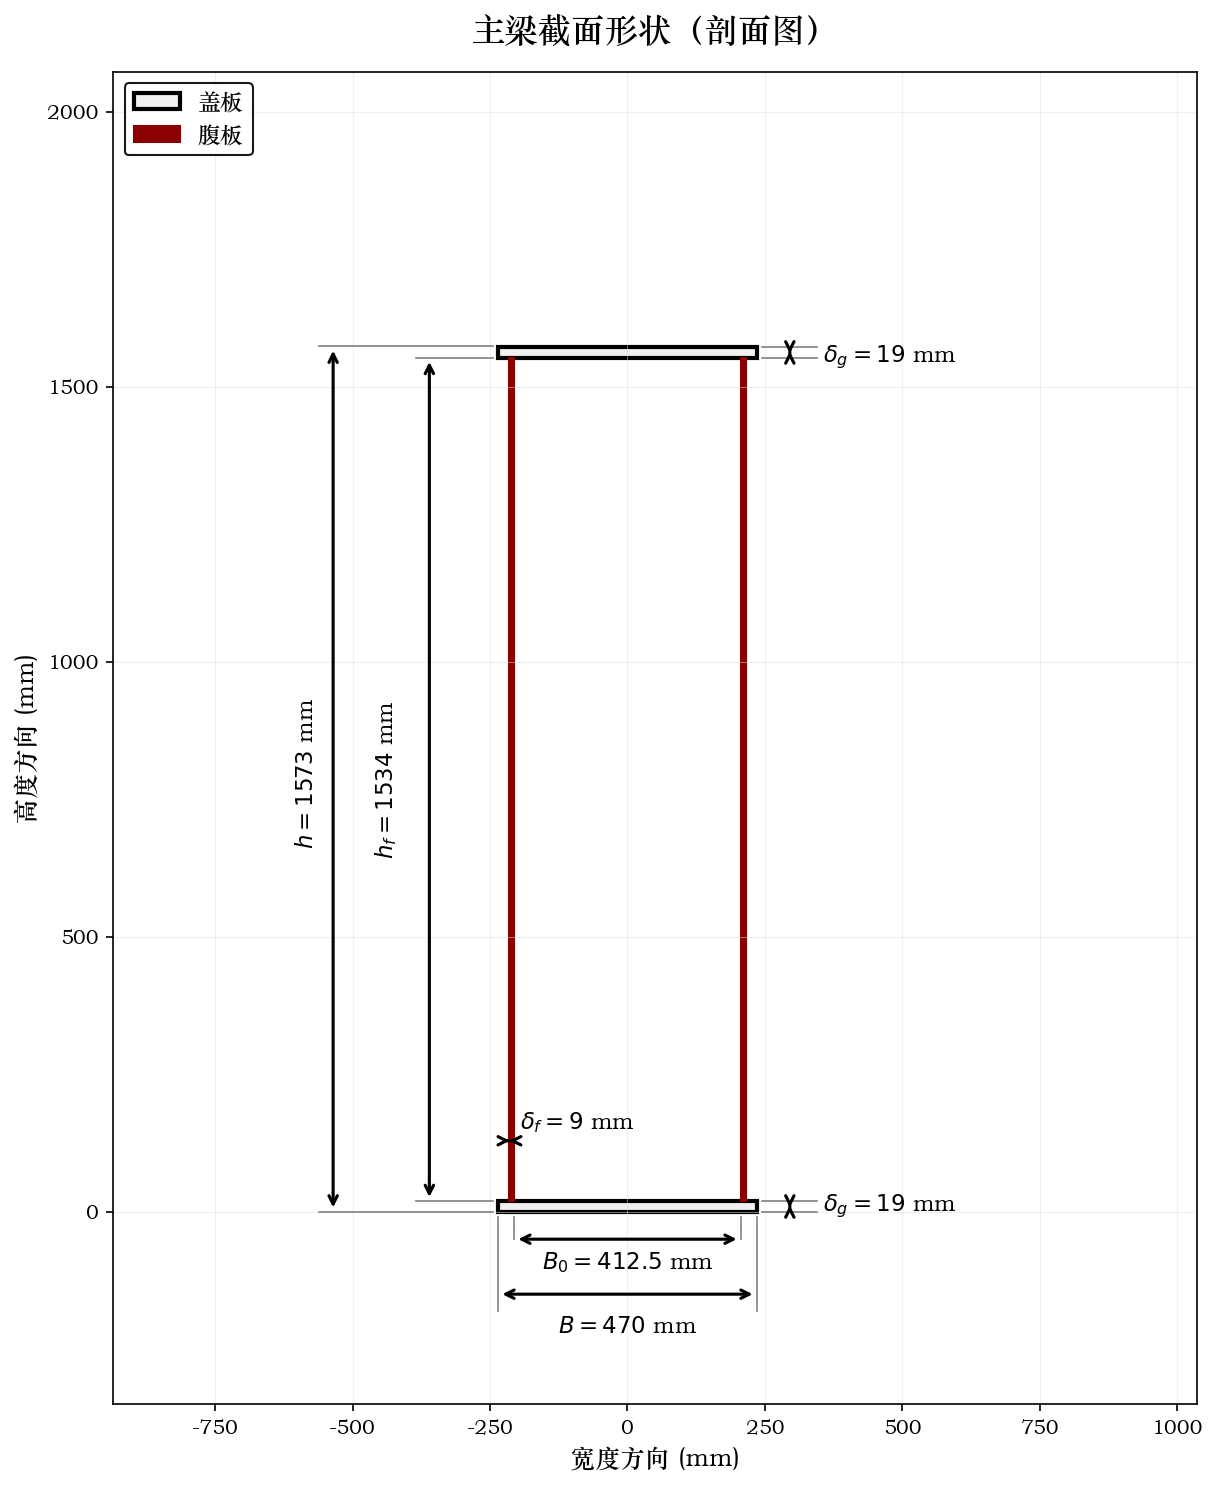

In [292]:
# 创建第一个图形（截面图）
fig1, ax1 = plt.subplots(1, 1, figsize=(14, 10))
fig1.set_facecolor('white')

# ========== 图1：截面形状 ==========
ax1.set_title("主梁截面形状（剖面图）", fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel("宽度方向 (mm)", fontsize=12, fontweight='bold')
ax1.set_ylabel("高度方向 (mm)", fontsize=12, fontweight='bold')
ax1.set_facecolor('white')

# 绘制上盖板
upper_cover = patches.Rectangle(
    (-B_selected/2, h_f + delta_g_selected),  # 左下角
    B_selected,  # 宽
    delta_g_selected,  # 高
    facecolor='#F0F0F0', edgecolor='black', linewidth=2, label='盖板'
)
ax1.add_patch(upper_cover)

# 绘制下盖板
lower_cover = patches.Rectangle(
    (-B_selected/2, 0),  # 左下角
    B_selected,  # 宽
    delta_g_selected,  # 高
    facecolor='#F0F0F0', edgecolor='black', linewidth=2,
)
ax1.add_patch(lower_cover)

# 绘制腹板两侧
# 第一个坐标为左下角的坐标
web_left = patches.Rectangle(
    (-B0_selected/2 - delta_f_selected, delta_g_selected),  # 左腹板
    delta_f_selected, h_f, facecolor='darkred', edgecolor='darkred', linewidth=1, label='腹板'
)
web_right = patches.Rectangle(
    (B0_selected/2, delta_g_selected),  # 右腹板
    delta_f_selected, h_f, facecolor='darkred', edgecolor='darkred', linewidth=1
)
ax1.add_patch(web_left)
ax1.add_patch(web_right)

# 计算边界
x_min = -B_selected/2 - 700
x_max = B_selected/2 + 800
y_min = -350
y_max = h_selected + 500


# 竖直方向的双箭头线
ax1.annotate("",
    xy=(-B_selected/2 - 300, h_selected),   # 上端
    xytext=(-B_selected/2 - 300, 0),                   # 下端
    arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5)
)
# 左尺寸线
ax1.plot([-B_selected/2 - 10, -B_selected/2 - 325], 
         [0, 0], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax1.plot([-B_selected/2 - 10, -B_selected/2 - 325], 
         [h_selected, h_selected], 
         color='gray', linewidth=0.8, linestyle='-')
# 尺寸文本（竖直显示，位于标注线左侧）
ax1.text(-B_selected/2 - 330, (h_selected + delta_g_selected)/2,
         f"$h = {h_selected:.0f}$ mm",
         ha='right', va='center', fontsize=11, fontweight='bold', rotation=90)

# 2. 总宽度B标注
# 左尺寸线
ax1.plot([-B_selected/2, -B_selected/2], [-10, -180], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax1.plot([B_selected/2, B_selected/2], [-10, -180], 
         color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax1.annotate("", xy=(-B_selected/2, -150), 
             xytext=(B_selected/2, -150),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
ax1.text(0, -190, 
         f"$B = {B_selected:.0f}$ mm", 
         ha='center', va='top', fontsize=11, fontweight='bold')

# 3. 上盖板厚度δ_g标注
# 左尺寸线
ax1.plot([B_selected/2 + 10, B_selected/2 + 110], [h_f + 2 * delta_g_selected, h_f + 2 * delta_g_selected], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax1.plot([B_selected/2 + 10, B_selected/2 + 110], [h_f + delta_g_selected, h_f + delta_g_selected], 
         color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax1.annotate("", xy=(B_selected/2 + 60, h_f + 2 * delta_g_selected), 
             xytext=(B_selected/2 + 60, h_f + delta_g_selected),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))

# 尺寸文本
ax1.text(B_selected/2 + 120, h_f + 2*delta_g_selected/2, 
         f"$δ_g = {delta_g_selected:.0f}$ mm", 
         ha='left', va='center', fontsize=11, fontweight='bold')

# 4. 下盖板厚度δ_g标注
# 左尺寸线
ax1.plot([B_selected/2 + 10, B_selected/2 + 110], [delta_g_selected, delta_g_selected], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax1.plot([B_selected/2 + 10, B_selected/2 + 110], [0, 0], 
         color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax1.annotate("", xy=(B_selected/2 + 60, delta_g_selected), 
             xytext=(B_selected/2 + 60, 0),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
ax1.text(B_selected/2 + 120, delta_g_selected/2, 
         f"$δ_g = {delta_g_selected:.0f}$ mm", 
         ha='left', va='center', fontsize=11, fontweight='bold')

# 5. 腹板间距B_0标注
# 左尺寸线
ax1.plot([-B0_selected/2, -B0_selected/2], [-10, -50], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax1.plot([B0_selected/2, B0_selected/2], [-10, -50], 
         color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax1.annotate("", xy=(-B0_selected/2, -50), 
             xytext=(B0_selected/2, -50),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
ax1.text(0, -70, 
         f"$B_0 = {B0_selected:.1f}$ mm", 
         ha='center', va='top', fontsize=11, fontweight='bold')


# 6. 腹板厚度δ_f标注（左腹板下部）

# 双箭头线
ax1.annotate("", xy=(-B0_selected/2 - delta_f_selected, delta_g_selected + 110), 
             xytext=(-B0_selected/2, delta_g_selected + 110),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
ax1.text(-B0_selected/2 - delta_f_selected/2 + 120, delta_g_selected + 120, 
         f"$δ_f = {delta_f_selected:.0f}$ mm", 
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# 7. 腹板高度h_f标注 - 竖直方向
# 左尺寸线
ax1.plot([-B_selected/2 - 10, -B_selected/2 - 150], 
         [delta_g_selected, delta_g_selected], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax1.plot([-B_selected/2 - 10, -B_selected/2 - 150], 
         [h_f + delta_g_selected, h_f + delta_g_selected], 
         color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax1.annotate("", xy=(-B_selected/2 - 125, delta_g_selected), 
             xytext=(-B_selected/2 - 125, h_f + delta_g_selected),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本 - 竖直方向，位于标注线左侧
ax1.text(-B_selected/2 - 180, h_f/2 + delta_g_selected, 
         f"$h_f = {h_f:.0f}$ mm", 
         ha='right', va='center', fontsize=11, fontweight='bold', rotation=90)

# 计算边界
x_min = -B_selected/2 - 700
x_max = B_selected/2 + 800
y_min = -350
y_max = h_selected + 500

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.grid(True, color='#E0E0E0', linewidth=0.5, alpha=0.5)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9, edgecolor='black')
ax1.set_aspect('equal', adjustable='box')

# 截面图调整布局并显示
fig1.tight_layout()
plt.figure(fig1.number)
plt.show()


绘制主梁正视图...


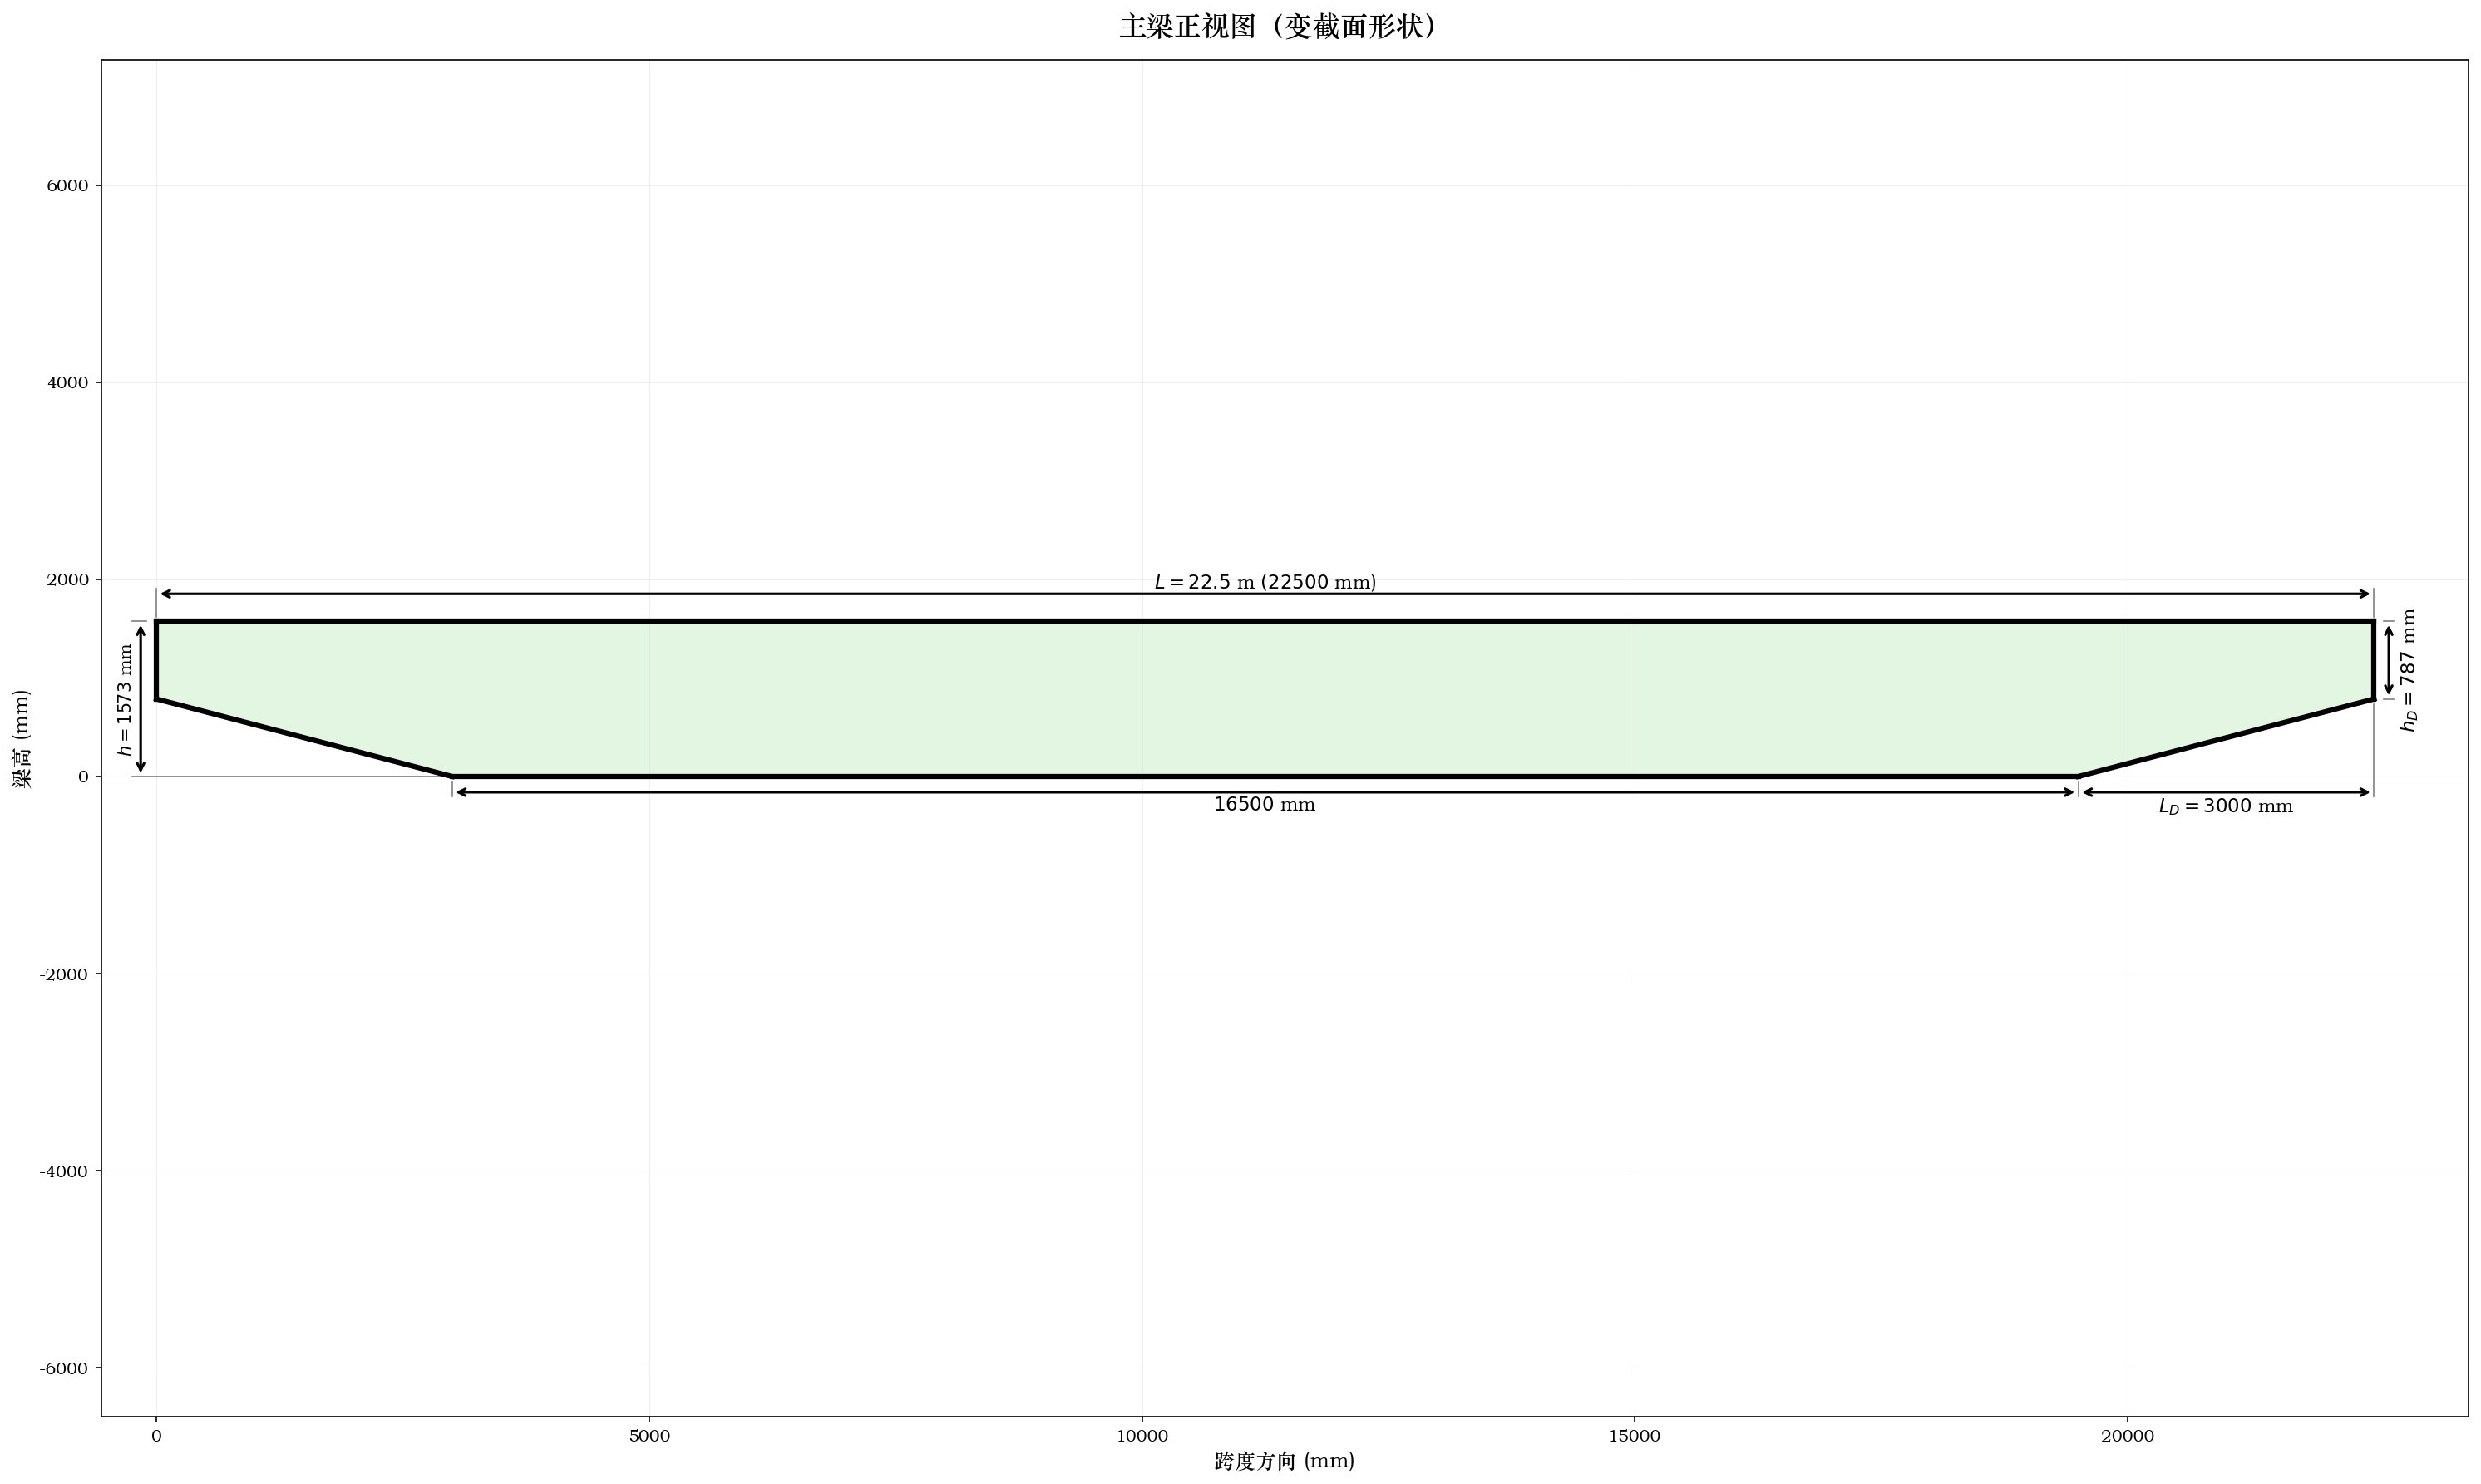

主梁截面与正视图绘制完成！


In [293]:
# ========== 绘制主梁正视图 ==========
print("绘制主梁正视图...")

# 创建第二个图形（正视图）
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 12))
fig2.set_facecolor('white')

# ========== 主梁正视图（变截面） ==========
ax2.set_title("主梁正视图（变截面形状）", fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel("跨度方向 (mm)", fontsize=12, fontweight='bold')
ax2.set_ylabel("梁高 (mm)", fontsize=12, fontweight='bold')
ax2.set_facecolor('white')

# 梁底部是水平的，在y=0
# 梁顶部：两端高度为h_D_selected，中间高度为h_selected
# 变截面区从端部到L_D_selected线性变化
# 定义关键点
x_points = [0, L_D_selected, l_mm - L_D_selected, l_mm]
# 顶部线y坐标：两端为h_D_selected，中间为h_selected
y_top = [h_selected, h_selected, h_selected, h_selected]
# 底部线y坐标：始终为0
y_bottom = [h_D_selected, 0, 0, h_D_selected]
# 填充主梁主体区域
ax2.fill_between(x_points, y_bottom, y_top,
                 color='#D0F0D0', alpha=0.6, zorder=1,
                 edgecolor='none')

# 黑色轮廓线绘制 
ax2.plot([0, l_mm], [h_selected, h_selected],
         color='black', linewidth=3, zorder=5)
# 左端坡形底
ax2.plot([0, L_D_selected], [h_D_selected, 0],
         color='black', linewidth=3, zorder=5)
# 中部直底
ax2.plot([L_D_selected, l_mm - L_D_selected], [0, 0],
         color='black', linewidth=3, zorder=5)
# 右端坡形底
ax2.plot([l_mm - L_D_selected, l_mm], [0, h_D_selected],
         color='black', linewidth=3, zorder=5)

# 左右立边封闭轮廓
ax2.plot([0, 0], [h_selected, h_D_selected],
         color='black', linewidth=3, zorder=5)
ax2.plot([l_mm, l_mm], [h_selected, h_D_selected],
         color='black', linewidth=3, zorder=5)

# 1. 总长度L标注 - 调整位置
# 左尺寸线
ax2.plot([0, 0], [h_selected + 50, h_selected + 330], color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax2.plot([l_mm, l_mm], [h_selected + 50, h_selected + 330], color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax2.annotate("", xy=(0, h_selected + 280), xytext=(l_mm, h_selected + 280),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
ax2.text(l_mm/2, h_selected + 500, f"$L = {l_mm/1000:.1f}$ m $({l_mm:.0f}$ mm)", 
         ha='center', va='top', fontsize=11, fontweight='bold')


# 3. 变截面区长度L_D标注（右端） - 调整位置
# 左尺寸线
ax2.plot([l_mm - L_D_selected, l_mm - L_D_selected], [-60, -200], 
         color='gray', linewidth=0.8, linestyle='-')
# 右尺寸线
ax2.plot([l_mm, l_mm], [h_selected - h_D_selected -50, -200], color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax2.annotate("", xy=(l_mm - L_D_selected, -160), xytext=(l_mm, -160),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
ax2.text(l_mm - L_D_selected/2, -200, f"$L_D = {L_D_selected:.0f}$ mm", 
         ha='center', va='top', fontsize=11, fontweight='bold')

# 4. 中间区长度标注 - 调整位置

# 双箭头线
ax2.plot([L_D_selected, L_D_selected], [-60, -200], color='gray', linewidth=0.8, linestyle='-')
ax2.annotate("", xy=(L_D_selected, -160), xytext=(l_mm - L_D_selected, -160),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本
mid_length = l_mm - 2*L_D_selected
ax2.text(l_mm/2, -200, f"${mid_length:.0f}$ mm", 
         ha='center', va='top', fontsize=11, fontweight='bold')

# 5. 中间梁高h标注（中间位置） - 调整位置，远离梁体
# 下尺寸线
ax2.plot([-250, -100 + L_D_selected], [0, 0], color='gray', linewidth=0.8, linestyle='-')
# 上尺寸线
ax2.plot([-250, -100], [h_selected, h_selected], color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax2.annotate("", xy=(-160, 0), xytext=(-160, h_selected),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本 - 竖直方向，位于标注线左侧
ax2.text(-220, h_selected/2, f"$h = {h_selected:.0f}$ mm", 
         ha='right', va='center', fontsize=10, fontweight='bold', rotation=90)

# 7. 端部梁高h_D标注（右端） - 调整位置，远离梁端
# 下尺寸线 - 向右移动更多
ax2.plot([l_mm + 100, l_mm + 200], [h_D_selected, h_D_selected], color='gray', linewidth=0.8, linestyle='-')
# 上尺寸线 - 向右移动更多
ax2.plot([l_mm + 100, l_mm + 200], [h_selected, h_selected], color='gray', linewidth=0.8, linestyle='-')
# 双箭头线
ax2.annotate("", xy=(l_mm + 150, h_D_selected), xytext=(l_mm + 150, h_selected),
             arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5))
# 尺寸文本 - 竖直方向，位于标注线左侧
ax2.text(l_mm + 250, h_selected/2+300, f"$h_D = {h_D_selected:.0f}$ mm", 
         ha='left', va='center', fontsize=11, fontweight='bold', rotation=90)

# 设置坐标轴范围 - 进一步扩大显示空间
x_min_view = -100
x_max_view = l_mm + 500
y_min_view = -900  # 底部留足够空间给标注
y_max_view = max(h_selected, h_D_selected) + 100  # 顶部留更多空间

# 设置坐标轴范围
ax2.set_xlim(x_min_view, x_max_view)
ax2.set_ylim(y_min_view, y_max_view)

# 强制设置x,y轴比例为1:1
ax2.set_aspect('equal', adjustable='datalim')

# 添加网格
ax2.grid(True, color='#E0E0E0', linewidth=0.5, alpha=0.5)

# 正视图调整布局并显示
fig2.tight_layout()
plt.figure(fig2.number)
plt.show()

print("主梁截面与正视图绘制完成！")

In [297]:
from matplotlib.patches import Rectangle, Polygon

def generate_markdown_report():
    """生成Markdown格式的计算报告"""
    
    # 获取当前时间
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"工程力学计算报告_主梁设计与校核_{current_time}.md"
    
    # 确保x_points是numpy数组
    global x_points
    if not isinstance(x_points, np.ndarray):
        x_points = np.array(x_points)
    
    # 单位转换函数
    def t_to_N(value_t):
        return value_t * 1000 * 9.81
    
    def m_to_mm(value_m):
        return value_m * 1000
    
    def Nmm_to_tm(value_Nmm):
        return value_Nmm / (1000 * 9.81 * 1000)
    
    # 生成车轮表 Markdown
    wheel_table_md = ""
    if 'wheel_table' in globals():
        wheel_table_md = (
            "| 直径 $D\\ (\\text{mm})$ | 钢轨型号 | 工作级别 | $P_{\\max}\\ (\\text{t})$ | 材料 |\n"
            "|---|---|---|---|---|\n"
        )
        for w in wheel_table:
            wheel_table_md += (
                f"| {w['D']} | {w['rail']} | {w['level']} | {w['Pmax']} | {w['mat']} |\n"
            )

    # 生成槽钢表 Markdown
    channel_table_md = ""
    if 'channel_table' in globals():
        channel_table_md = (
            "| 型号 | 高度 $h\\ (\\text{mm})$ | 宽度 $b\\ (\\text{mm})$ | 厚度 $t\\ (\\text{mm})$ | "
            "$A\\ (\\text{cm}^2)$ | $I_x\\ (\\text{cm}^4)$ | $I_y\\ (\\text{cm}^4)$ |\n"
            "|---|---|---|---|---|---|---|\n"
        )
        for c in channel_table:
            channel_table_md += (
                f"| {c['name']} | {c['h']} | {c['b']} | {c['t']} | {c['A_cm2']} | {c['Ix_cm4']} | {c['Iy_cm4']} |\n"
            )

    # 生成 C1 表 Markdown（横向排列）
    c1_table_md = ""
    if 'c1_table' in globals():
        keys = list(c1_table.keys())
        c1_table_md = (
            "| $\\dfrac{\\lambda}{h_f}$ | " + " | ".join(str(k) for k in keys) + " |\n"
        )
        c1_table_md += "|" + " --- |" * (len(keys) + 1) + "\n"
        c1_table_md += (
            "| $C_1$ | " + " | ".join(str(c1_table[k]) for k in keys) + " |\n"
        )

    # 生成 Iy1 数据表 Markdown
    iy1_table_md = ""
    if 'channel_table' in globals() and 'Iy1_mm4' in channel_table[0]:
        iy1_table_md = (
            "| 型号 | 高度 $h\\ (\\text{mm})$ | 宽度 $b\\ (\\text{mm})$ | 面积 $A\\ (\\text{cm}^2)$ | "
            "$I_{y1}\\ (\\text{mm}^4)$ |\n"
            "|---|---|---|---|---|\n"
        )
        # 按 Iy1 从小到大排序
        sorted_channels = sorted(channel_table, key=lambda x: x.get('Iy1_mm4', 0))
        for c in sorted_channels:
            iy1_table_md += (
                f"| {c['name']} | {c['h']} | {c['b']} | {c['A_cm2']} | {c.get('Iy1_mm4', 0):.0f} |\n"
            ) 
    # 报告内容
    report_content = f'''# 工程力学计算报告 - 主梁设计与校核

**生成时间**: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
**报告编号**: {current_time}

---

## 1. 设计参数

### 1.1 原始参数

| 参数 | 符号 | 数值 | 单位 | 说明 |
|------|------|------|------|------|
| 跨度 | $l$ | ${l:.1f}$ | $\\text{{m}}$ | 主梁跨度 |
| 最大起吊重量 | $Q_{{max}}$ | {Q_max:.2f} | $\\text{{t}}$ | 最大起吊重量 |
| 小车重量 | $G_x$ | ${G_x:.2f}$ | $\\text{{t}}$ | 小车自重 |
| 驾驶舱重量 | $G'_c$ | ${G_c_prime:.2f}$ | $\\text{{t}}$ | 集中载荷（驾驶舱） |
| 传动系统重量 | $G'_q$ | ${G_q_prime:.2f}$ | $\\text{{t}}$ | 传动系统重量 |
| 均布重量 | $q'_y$ | ${q_y_prime:.3f}$ | $\\text{{t/m}}$ | 运行机构产生的均布重量 |
| 梁身自重 | $q'_w$ | ${q_w_prime:.3f}$ | $\\text{{t/m}}$ | 梁身自重 |
| 冲击系数 | $K$ | ${K:.2f}$ | $-$ | 轨道不平整冲击系数 |
| 动力系数 | $\Phi$ | ${Phi:.2f}$ | $-$ | 起吊制动动力系数 |
| 驾驶舱位置 | $l_c$ | ${l_c:.2f}$ | $\\text{{m}}$ | 驾驶舱距左支点距离 |
| 前轮距重心 | $t_1$ | ${t1:.2f}$ | $\\text{{m}}$ | 小车前轮到重心距离 |
| 后轮距重心 | $t_2$ | ${t2:.2f}$ | $\\text{{m}}$ | 小车后轮到重心距离 |

### 1.2 冲击矫正计算

根据冲击矫正公式：

$$G_q = K G'_q = {K} \\times {G_q_prime} = {G_q:.2f} \\text{{ t}}$$

$$G_c = K G'_c = {K} \\times {G_c_prime} = {G_c:.2f} \\text{{ t}}$$

$$q' = q'_y + q'_w = {q_y_prime} + {q_w_prime} = {q_prime:.3f} \\text{{ t/m}}$$

$$q = K q' = {K} \\times {q_prime:.3f} = {q:.3f} \\text{{ t/m}}$$

### 1.3 车轮压力计算

$$R = \\frac{{G_x}}{{2}} + \\Phi \\frac{{Q}}{{2}} = \\frac{{{G_x}}}{{2}} + {Phi} \\times \\frac{{{Q_max}}}{{2}} = {R:.2f} \\text{{ t}}$$

### 1.4 支座反力计算

左支座反力：

$$R_A = \\frac{{ql}}{{2}} + \\frac{{G_q}}{{2}} + \\frac{{G_c(l-l_c)}}{{l}}$$
$$= \\frac{{{q:.3f} \\times {l}}}{{2}} + \\frac{{{G_q:.2f}}}{{2}} + \\frac{{{G_c:.2f} \\times ({l} - {l_c})}}{{{l}}} = {R_A_fixed:.2f} \\text{{ t}}$$

---

## 2. 内力计算

### 2.1 内力计算公式

小车在位置 $x$（小车左端距离左支点）时的内力计算公式：

#### 2.1.1 小车产生的内力

$$Q_R = \\frac{{R(l - t_1 - x)}}{{l}}$$
$$M_R = \\frac{{R(l - t_1 - x)x}}{{l}}$$

#### 2.1.2 分段计算

**区间 1: $0 \\leq x < l_c$**

均布载荷：
$$Q_q = \\frac{{ql}}{{2}} - qx$$
$$M_q = \\frac{{qlx}}{{2}} - \\frac{{qx^2}}{{2}}$$

传动系统：
$$Q_{{G_q}} = \\frac{{G_q}}{{2}}$$
$$M_{{G_q}} = \\frac{{G_q x}}{{2}}$$

驾驶舱：
$$Q_{{G_c}} = \\frac{{G_c(l - l_c)}}{{l}}$$
$$M_{{G_c}} = \\frac{{G_c(l - l_c)x}}{{l}}$$

**区间 2: $l_c \\leq x < l/2$**

均布载荷：
$$Q_q = \\frac{{ql}}{{2}} - qx$$
$$M_q = \\frac{{qlx}}{{2}} - \\frac{{qx^2}}{{2}}$$

传动系统：
$$Q_{{G_q}} = \\frac{{G_q}}{{2}}$$
$$M_{{G_q}} = \\frac{{G_q x}}{{2}}$$

驾驶舱：
$$Q_{{G_c}} = -\\frac{{G_c l_c}}{{l}}$$
$$M_{{G_c}} = \\frac{{G_c l_c(l - x)}}{{l}}$$

**区间 3: $l/2 \\leq x \\leq l$**

均布载荷：
$$Q_q = \\frac{{ql}}{{2}} - qx$$
$$M_q = \\frac{{qlx}}{{2}} - \\frac{{qx^2}}{{2}}$$

传动系统：
$$Q_{{G_q}} = -\\frac{{G_q}}{{2}}$$
$$M_{{G_q}} = \\frac{{G_q (l - x)}}{{2}}$$

驾驶舱：
$$Q_{{G_c}} = -\\frac{{G_c l_c}}{{l}}$$
$$M_{{G_c}} = \\frac{{G_c l_c(l - x)}}{{l}}$$

#### 2.1.3 总内力

总剪力：
$$Q_{{total}} = Q_q + Q_{{G_q}} + Q_{{G_c}} + Q_R$$

总弯矩：
$$M_{{total}} = M_q + M_{{G_q}} + M_{{G_c}} + M_R$$

### 2.2 最大内力值

- **最大剪力**: $Q_{{max}} = {max(abs(Q) for Q in Q_total_list):.2f}$ t
- **最大弯矩**: $M_{{max}} = {max(abs(M) for M in M_total_list):.2f}$ t·m

### 2.3 关键位置内力

| 位置 $x (m)$ | 总剪力 $Q (t)$ | 总弯矩 $M (t·m)$ | 小车位置说明 |
|--------------|---------------|-----------------|-------------|
| 0.00 | {Q_total_list[0]:.2f} | {M_total_list[0]:.2f} | 左支座 |
| {l_c:.2f} | {Q_total_list[np.argmin(np.abs(x_points - l_c))]:.2f} | {M_total_list[np.argmin(np.abs(x_points - l_c))]:.2f} | 驾驶舱位置 |
| {l/2:.2f} | {Q_total_list[len(Q_total_list)//2]:.2f} | {M_total_list[len(M_total_list)//2]:.2f} | 跨中位置 |
| {l:.2f} | {Q_total_list[-1]:.2f} | {M_total_list[-1]:.2f} | 右支座 |

### 2.4 内力图示



---

## 3. 材料参数

- **材料**: Q235钢
- **屈服强度**: $\\sigma_s = {sigma_s}$ MPa
- **弹性模量**: $E = {E/1000:.0f}$ GPa
- **安全系数**: $\\eta = {eta}$
- **许用应力**: $[\\sigma] = \\sigma_s/\\eta = {sigma_allow:.2f}$ MPa
- **许用剪应力**: $[\\tau] = [\\sigma]/\\sqrt{{3}} = {tau_allow:.2f}$ MPa
- **许用挠度**: $[f] = L/700 = {f_allow:.1f}$ mm

---

## 4. 主梁高度确定

### 4.1 刚度条件确定梁高

$$h_1 = \\frac{{[\\sigma]L^2}}{{24EM_{{max}}[f]}}\\cdot (4M_p +5M_q)$$

其中：
- $M_p = \\frac{{(R+G_q)L}}{{4}} = {Nmm_to_tm(M_p_Nmm):.2f}$ t·m = {M_p_Nmm:.0f} N·mm
- $M_q = \\frac{{qL^2}}{{8}} = {Nmm_to_tm(M_q_Nmm):.2f}$ t·m = {M_q_Nmm:.0f} N·mm

计算得：$h_1 = {h1_mm:.1f}$ mm

### 4.2 强度条件确定梁高

提前确认腹板厚度,考虑到负载情况，选择腹板厚度 $\\delta_f = {delta_f_selected}$ mm

$$h_2 = \\sqrt{{\\frac{{M_{{max}}}}{{\\delta_f[\\sigma]}}}}$$

腹板厚度 $\\delta_f = {delta_f_selected}$ mm，计算得：$h_2 = {h2_mm:.1f}$ mm

### 4.3 经济性条件确定梁高

$$h_3 = 0.01\\sqrt[3]{{\\frac{{(5M_q+4M_p)L^2}}{{48\\delta_f[f]}}}}$$

其中 $M_q$ 和 $M_p$ 的单位为 kg·cm，计算得：$h_3 = {h3_mm:.1f}$ mm

### 4.4 梁高选择

| 条件 | 计算高度 (mm) | 选择依据 |
|------|---------------|----------|
| 刚度条件 $h_1$ | {h1_mm:.1f} | 满足刚度要求 |
| 强度条件 $h_2$ | {h2_mm:.1f} | 满足强度要求 |
| 经济条件 $h_3$ | {h3_mm:.1f} | 经济性最优 |

**选择结果**: $h = {h_selected:.1f}$ mm

验证：$h/L = {h_selected/l_mm:.4f}$，在推荐范围 $1/18 \\sim 1/14$ 内。

---

## 5. 截面设计

### 5.1 腹板设计

- 腹板高度: $h_f = 0.975h = 0.975 \\times {h_selected:.1f} = {h_f:.1f}$ mm
- 腹板厚度: $\\delta_f = {delta_f_selected}$ mm
- 腹板面积: $F_f = 2\\delta_f h_f = 2 \\times {delta_f_selected} \\times {h_f:.1f} = {F_f:.1f}$ mm²

### 5.2 盖板设计

- 腹板间距: $B_0 = {B0_selected:.1f}$ mm (满足 $B_0/L \\geq 1/60$)
- 盖板宽度: $B = B_0 + 2(20+\\delta_f) = {B0_selected:.1f} + 2(20+{delta_f_selected}) = {B_selected:.0f}$ mm
- 盖板厚度: $\\delta_g = {delta_g_selected:.0f}$ mm
- 单块盖板面积: $F_g1 = B\\delta_g = {B_selected:.0f} \\times {delta_g_selected:.0f} = {B_selected*delta_g_selected:.0f}$ mm²

### 5.3 梁端设计

- 梁端高度: $h_D = {h_D_selected:.1f}$ mm
- 梁端长度: $L_D = {L_D_selected:.1f}$ mm

### 5.4 截面计算结果图示


### 5.5 截面特性计算

#### 5.5.1 所需惯性矩

根据刚度条件，所需惯性矩为：

$$I_x = \\frac{{L^2}}{{48E[f]}}(5M_q + 4M_p)$$

代入数值：
$$I_x = \\frac{{{l_mm:.0f}^2}}{{48 × {E:.0f} × {f_allow:.1f}}} × (5 × {M_q_Nmm:.0f} + 4 × {M_p_Nmm:.0f}) = {I_x_required:.0f} \\text{{ mm}}^4$$

#### 5.5.2 腹板惯性矩

$$I_{{xf}} = \\frac{{h_f^2 F_f}}{{12}} = \\frac{{{h_f:.1f}^2 \\times {F_f:.1f}}}{{12}} = {I_xf:.0f} \\text{{ mm}}^4$$

#### 5.5.3 盖板所需惯性矩

$$I_{{xg}} = I_x - I_{{xf}} = {I_x_required:.0f} - {I_xf:.0f} = {I_xg_required:.0f} \\text{{ mm}}^4$$

#### 5.5.4 盖板总面积

$$F_{{gtotal}} = \\frac{{4I_{{xg}}}}{{h^2}} = \\frac{{4 \\times {I_xg_required:.0f}}}{{{h_selected:.1f}^2}} = {F_g_total:.1f} \\text{{ mm}}^2$$

#### 5.5.5 实际截面惯性矩

盖板对x轴的惯性矩：

$$I_{{xg\\_actual}} = 2 \\left[ \\frac{{B\\delta_g^3}}{{12}} + B\\delta_g \\left(\\frac{{h_f + \\delta_g}}{{2}}\\right)^2 \\right]$$

腹板对x轴的惯性矩：

$$I_{{xf\\_actual}} = 2 \\times \\frac{{\\delta_f h_f^3}}{{12}} = \\frac{{\\delta_f h_f^3}}{{6}}$$

总惯性矩：

$$I_x = I_{{xg\\_actual}} + I_{{xf\\_actual}} = \\frac{{\\delta_g B h^2}}{{2}} + \\frac{{\\delta_f h_f^3}}{{6}} + 2B\\delta_g \\left(\\frac{{\\delta_g + h_f}}{{2}}\\right)^2$$

代入实际数值：
$$I_x = {I_x_actual:.0f} \\text{{ mm}}^4$$

y轴惯性矩：

$$I_y = I_{{yg}} + I_{{yf}} = \\frac{{\\delta_f h_f(B_0 + 2\\delta_f)^2}}{{2}} + \\frac{{\\delta_g B_0^3}}{{6}} + 2\\delta_f h_f \\left(\\frac{{\\delta_f + B_0}}{{2}}\\right)^2 = {I_y_actual:.0f} \\text{{ mm}}^4$$

#### 5.5.6 抗弯截面系数

$$W_x = \\frac{{I_x}}{{h/2}} = \\frac{{{I_x_actual:.0f}}}{{{h_selected:.1f}/2}} = {W_x:.0f} \\text{{ mm}}^3$$

$$W_y = \\frac{{I_y}}{{B/2}} = \\frac{{{I_y_actual:.0f}}}{{{B_selected:.0f}/2}} = {W_y:.0f} \\text{{ mm}}^3$$

---

## 6. 强度校核

### 6.1 最大正应力校核

$$\\sigma_{{max}} = \\frac{{M_{{max}}}}{{W_x}} + \\frac{{M_{{s max}}}}{{W_y}} \\leq [\\sigma]$$

其中 $M_{{s max}} = 0.1M_{{max}} = 0.1 \\times {M_max_Nmm:.0f} = {M_s_max:.0f}$ N·mm

计算得：
$$\\sigma_{{max}} = \\frac{{{M_max_Nmm:.0f}}}{{{W_x:.0f}}} + \\frac{{{M_s_max:.0f}}}{{{W_y:.0f}}} = {sigma_max:.2f} \\text{{ MPa}}$$

许用应力：$[\\sigma] = {sigma_allow:.2f}$ MPa

**结论**: {'通过' if sigma_max <= sigma_allow else '不通过'} (安全冗余: {sigma_allow/sigma_max:.2f})

### 6.2 最大剪应力校核

$$\\tau_{{max}} = \\frac{{Q_{{max}}}}{{2h_f\\delta_f}} \\leq [\\tau]$$

计算得：
$$\\tau_{{max}} = \\frac{{{Q_max_N:.0f}}}{{2 × {h_f:.1f} × {delta_f_selected}}} = {tau_max_avg:.2f} \\text{{ MPa}}$$

许用剪应力：$[\\tau] = {tau_allow:.2f} MPa$

**结论**: {'通过' if tau_max_avg <= tau_allow else '不通过'} (安全冗余: {tau_allow/tau_max_avg:.2f})

### 6.3 变截面处复合应力校核

$$\\sigma_F = \\sqrt{{\\sigma_b^2 + 3\\tau_b^2}} \\leq 1.1[\\sigma]$$

其中：
- $\\sigma_b = \\frac{{M_b}}{{W_{{xb}}}} + \\frac{{M_{{sb}}}}{{W_{{yb}}}} = {sigma_b:.2f}$ MPa
- $\\tau_b = \\frac{{Q_b}}{{2h_f\\delta_f}} = {tau_b:.2f}$ MPa

计算得：
$$\\sigma_F = \\sqrt{{{sigma_b:.2f}^2 + 3 \\times {tau_b:.2f}^2}} = {sigma_F:.2f} \\text{{ MPa}}$$

许用复合应力：$1.1[\\sigma] = 1.1 \\times {sigma_allow:.2f} = {1.1*sigma_allow:.2f}$ MPa

**结论**: {'通过' if sigma_F <= 1.1*sigma_allow else '不通过'} (安全冗余: {1.1*sigma_allow/sigma_F:.2f})

---

## 7. 刚度校核

$$f_{{max}} = \\frac{{R'L^3}}{{48EI_x}} \\leq [f]$$

其中：$R' = \\frac{{G_x + Q}}{{2}} = \\frac{{{G_x} + {Q_max}}}{{2}} = {R_prime:.1f}$ t = {R_prime_N:.0f} N

计算得：
$$f_{{max}} = \\frac{{{R_prime_N:.0f} × {l_mm:.0f}^3}}{{48 × {E:.0f} × {I_x_actual:.0f}}} = {f_max:.2f} \\text{{ mm}}$$

许用挠度：$[f] = {f_allow:.1f}$ mm

**结论**: {'通过' if f_max <= f_allow else '不通过'} (安全冗余: {f_allow/f_max:.2f})

---

## 8. 车轮压力计算与型号选择

### 8.1 车轮压力计算

已有 $R' = {R_prime:.2f}$ t 作为单侧两轮总反力，假定双轮布置，距点 $t_1 = {t1:.2f}$ m, $t_2 = {t2:.2f}$ m。

**计算原理**:
根据静力平衡条件，建立方程组：
1. $P_1 + P_2 = R'$ (垂直力平衡)
2. $P_1 \\cdot t_1 = P_2 \\cdot t_2$ (力矩平衡)

**详细计算过程**:
由力矩平衡方程得：$P_1 = P_2 \\cdot \\frac{{t_2}}{{t_1}}$
代入垂直力平衡方程：$P_2 \\cdot \\frac{{t_2}}{{t_1}} + P_2 = R'$
整理得：$P_2 \\left( \\frac{{t_2}}{{t_1}} + 1 \\right) = R'$
所以：$P_2 = R' \\cdot \\frac{{t_1}}{{t_1 + t_2}}$

同理可得：$P_1 = R' \\cdot \\frac{{t_2}}{{t_1 + t_2}}$

**计算结果**:
$$P_1 = R' \\cdot \\frac{{t_2}}{{t_1 + t_2}} = {R_prime:.2f} \\times \\frac{{{t2:.2f}}}{{{t1:.2f} + {t2:.2f}}} = {P1:.3f} \\text{{ t}}$$
$$P_2 = R' \\cdot \\frac{{t_1}}{{t_1 + t_2}} = {R_prime:.2f} \\times \\frac{{{t1:.2f}}}{{{t1:.2f} + {t2:.2f}}} = {P2:.3f} \\text{{ t}}$$

**选型依据**:
取较大值 $P_{{need}} = {P_need:.3f}$ t 进行车轮选型，以确保所有车轮都能承受最大轮压。

### 8.2 车轮选型表

{wheel_table_md if wheel_table_md else "车轮表数据未找到"}

### 8.3 车轮选型结果

**工作级别**: {work_level}

**选型原则**:
1. 根据工作级别筛选候选车轮
2. 在候选车轮中选择许用压力 $P_{{max}}$ 最接近且不小于 $P_{{need}}$ 的规格
3. 考虑经济性和标准化要求

**选型过程**:
- 需要压力: $P_{{need}} = {P_need:.3f}$ t
- 工作级别: {work_level}
- 候选车轮数量: {len([w for w in wheel_table if w['level'] == work_level])} 个
- 选型结果: $D{best['D']}$, 钢轨 {best['rail']}, $P_{{max}} = {best['Pmax']}$ t, 材料 {best['mat']}

**选型验证**:
- 与 $P_{{need}}$ 差值 = ${abs(best['Pmax'] - P_need):.3f}$ t
- 安全裕度: ${best['Pmax']/P_need:.2f}$
- {'满足要求' if best['Pmax'] >= P_need else '不满足要求，需要重新选型'}

**钢轨配套信息**:
钢轨型号 {best['rail']} 对应高度 $h_{{rail}} = {h_rail}$ mm

---
## 9. 腹板局部稳定与加筋需求判定

### 9.1 腹板高厚比验算

**计算公式：**

$$
\dfrac{{h_f}}{{\delta_f}} = \dfrac{{{h_f:.1f}}}{{{delta_f_selected}}} = {hf_over_delta:.1f}
$$

**规范要求：**

根据《钢结构设计标准》GB 50017‑2017，对于 Q235 钢材：

- 当 $\dfrac{{h_f}}{{\delta_f}} \le 80\sqrt{{\dfrac{{235}}{{\sigma_s}}}}$ 时，无局部压应力可不设加筋；  
- 当 $80\sqrt{{\dfrac{{235}}{{\sigma_s}}}} < \dfrac{{h_f}}{{\delta_f}} \le 170\sqrt{{\dfrac{{235}}{{\sigma_s}}}}$ 时，应设横向加筋；  
- 当 $\dfrac{{h_f}}{{\delta_f}} > 170\sqrt{{\dfrac{{235}}{{\sigma_s}}}}$ 时，应设横向与纵向加筋。

**阈值计算：**

$$
80\cdot\sqrt{{\dfrac{{235}}{{\sigma_s}}}} = 80\\times\sqrt{{\dfrac{{235}}{{\sigma_s}}}} = {th_80:.1f}
$$

$$
170\cdot\sqrt{{\dfrac{{235}}{{\sigma_s}}}} = 170\\times\sqrt{{\dfrac{{235}}{{\sigma_s}}}} = {th_170:.1f}
$$

### 9.2 加筋需求判定

根据规范计算结果：

1. **横向加筋需求**: {'需要' if need_transverse else '不需要'}
   - 判定依据: {f'题设默认有局部压应力，应设横向加筋' if need_transverse else '满足规范不设筋要求'}

2. **纵向加筋需求**: {'需要' if need_longitudinal else '不需要'}
   - 判定条件: $\dfrac{{h_f}}{{\delta_f}} = {hf_over_delta:.1f} {'>' if hf_over_delta > th_170 else '≤'} 170\\sqrt{{\dfrac{{235}}{{\sigma_s}}}} = {th_170:.1f}$
   - 规范要求: {'需设纵向加筋' if need_longitudinal else '可不设纵向加筋'}

---

## 10. 加筋位置与尺寸确定
### 10.1 大筋板（横向加筋）尺寸

**计算公式**：

大筋板宽度：
$$b_J \\geq \\frac{{h_f}}{{30}} + 40 = \\frac{{{h_f:.1f}}}{{30}} + 40 = {bJ_min:.1f} \\text{{ mm}}$$
**实际取值**： $b_J = {bJ:.0f}$ mm

大筋板厚度：
$$\\delta_J \\geq \\frac{{b_J}}{{15}} = \\frac{{{bJ:.0f}}}{{15}} = {deltaJ_min:.2f} \\text{{ mm}}$$
**实际取值**： $\\delta_J = {deltaJ:.0f}$ mm


### 10.2 小筋板尺寸确定

**计算公式**：

1. 小筋板宽度 $b'_J$：
{'**情况一：设置纵向加筋时**' if need_longitudinal else '**情况二：仅设置横向加筋时**'}
   
   {'纵向加筋至腹板受压边缘的距离 $h_1$：' if need_longitudinal else '按规范要求：'}
   {f'$$h_1 = \\frac{{1120 \\delta_f}}{{\\sqrt{{\\sigma}} + \\sigma_c}}$$' if need_longitudinal else ''}
   {f'$$\\sigma_c = \\frac{{P_1}}{{2 \\delta_f (50 + 2 h_{{\\text{{rail}}}})}}$$' if need_longitudinal else ''}

2. 规范要求：
   {f'应满足 $h_f/4 > h_1 > h_f/5$' if need_longitudinal else ''}

**计算过程**：

{f'**参数取值**：' if need_longitudinal else ''}
{f'$$\\delta_f = {delta_f_selected:.0f} \\text{{mm}}, \\quad \\sqrt{{\\sigma}} = \\sqrt{{{sigma_allow:.1f}}} = {np.sqrt(sigma_allow):.2f} \\text{{ MPa}}$$' if need_longitudinal else ''}
{f'$$P_1 = {P_need:.2f} \\text{{t}} = {P1_N:.0f} \\text{{N}}, \\quad h_{{\\text{{rail}}}} = {h_rail:.0f} \\text{{mm}}$$' if need_longitudinal else ''}

{f'**分步计算**：' if need_longitudinal else ''}
{f'1. 计算挤压应力：' if need_longitudinal else ''}
{f'$$\\sigma_c = \\frac{{{P1_N:.0f}}}{{2 \\times {delta_f_selected:.0f} \\times (50 + 2 \\times {h_rail:.0f})}} = {sigma_c:.3f} \\text{{MPa}}$$' if need_longitudinal else ''}

{f'2. 计算 $h_1$ 理论值：' if need_longitudinal else ''}
{f'$$h_1 = \\frac{{1120 \\times {delta_f_selected:.0f}}}{{{np.sqrt(sigma_allow):.2f} + {sigma_c:.3f}}} = {h1_raw:.1f} \\text{{mm}}$$' if need_longitudinal else ''}

{f'3. 规范范围检查：' if need_longitudinal else ''}
{f'$$\\frac{{h_f}}{{5}} = {h1_low:.1f} \\text{{mm}}, \\quad \\frac{{h_f}}{{4}} = {h1_high:.1f} \\text{{mm}}$$' if need_longitudinal else ''}
{f'$${h1_low:.1f} < {h1_raw:.1f} < {h1_high:.1f} \\quad \\text{{{("满足" if h1_low < h1_raw < h1_high else "不满足，需调整")}}}$$' if need_longitudinal else ''}

{f'4. 最终确定 $h_1$：' if need_longitudinal else ''}
{f'$$h_1 = {h1:.1f} \\text{{mm}}$$' if need_longitudinal else ''}

{f'5. 小筋板宽度 $b\'_J = h_1$' if need_longitudinal else f'小筋板宽度 $b\'_J = 0.3h_f = 0.3 \\times {h_f:.1f} = {bJ_small_raw:.1f} \\text{{mm}}$'}

**施工优化**：

为便于施工，将宽度取为最接近的10的倍数：
$$b'_J = \\text{{round}} \\left( \\frac{{{h1 if need_longitudinal else bJ_small_raw:.1f}}}{{10}} \\right) \\times 10 = {bJ_small:.0f} \\text{{mm}}$$

**最终取值**：

小筋板宽度：
$$b'_J = {bJ_small:.0f} \\text{{mm}}$$

小筋板厚度（与大筋板相同）：
$$\\delta'_J = \\delta_J = {deltaJ_small:.0f} \\text{{mm}}$$


### 10.3 加筋间距优化设计

**小筋板最大允许间距**:
根据规范，小筋板间距应满足：
$$\\lambda_0 \\leq (40\\sim50)\\delta_J$$
取中间值: $45\\delta_J = 45 \\times {deltaJ:.0f} = {lambda0_max:.0f} \\text{{ mm}}$

为便于施工，取50mm倍数:
$$\\lambda_0 = \\left\\lfloor \\frac{{{lambda0_max:.0f}}}{{50}} \\right\\rfloor \\times 50 = {lambda0:.0f} \\text{{ mm}}$$

**大筋板间距调整**:
初始设计值: $\\lambda = {lambda_mm:.1f} \\text{{ mm}}$
为使小筋板均匀布置且间距为50mm倍数，重新调整:
- 分段数: $n = {n_segments}$
- 调整后小筋板间距: $\\lambda'_0 = {actual_lambda0:.0f} \\text{{ mm}}$
- 调整后大筋板间距: $\\lambda' = n \\times \\lambda'_0 = {actual_lambda_mm:.0f} \\text{{ mm}}$

**限制条件验证**:
1. 大筋板间距:
   $$0.5h_f = {0.5*h_f:.0f} \\text{{ mm}} \\leq \\lambda' = {actual_lambda_mm:.0f} \\text{{ mm}} \\leq 3000 \\text{{ mm}} \\quad \\text{{{'✓ 满足' if 0.5*h_f <= actual_lambda_mm <= 3000 else '✗ 不满足'}}}$$

2. 小筋板间距:
   $$\\lambda'_0 = {actual_lambda0:.0f} \\text{{ mm}} \\leq \\lambda_{{0,\\max}} = {lambda0_max:.0f} \\text{{ mm}} \\quad \\text{{{'✓ 满足' if actual_lambda0 <= lambda0_max else '✗ 不满足'}}}$$

3. 施工便利性:
   $$\\lambda'_0 = {actual_lambda0:.0f} \\text{{ mm}} \\text{{ 是50mm倍数}} \\quad \\text{{{'✓ 满足' if actual_lambda0 % 50 == 0 else '✗ 不满足'}}}$$
   $$\\lambda' = {actual_lambda_mm:.0f} \\text{{ mm}} \\text{{ 是50mm倍数}} \\quad \\text{{{'✓ 满足' if actual_lambda_mm % 50 == 0 else '✗ 不满足'}}}$$

### 10.4 最终加筋布置方案

**大筋板**:
- 尺寸: $b_J \\times \\delta_J = {bJ:.0f} \\times {deltaJ:.0f} \\text{{ mm}}$
- 间距: $\\lambda = {actual_lambda_mm:.0f} \\text{{ mm}} \\ ({actual_lambda_mm/1000:.2f} \\text{{ m}})$

**小筋板**:
- 尺寸: $b'_J \\times \\delta'_J = {bJ_small:.1f} \\times {deltaJ_small:.0f} \\text{{ mm}}$
- 数量: $n_0 = {n_small} \\text{{ 个}}$
- 间距: $\\lambda_0 = {actual_lambda0:.0f} \\text{{ mm}} \\ ({actual_lambda0/1000:.2f} \\text{{ m}})$

**布置方式**: 每 {n_segments} 段小筋板间距设置一个大筋板，形成均匀布置。

---
## 11. 纵向加筋型钢选型

### 11.1 纵向加筋需求

纵向加筋需求: {'需要' if need_longitudinal else '不需要'}

### 11.2 纵向加筋计算

**基本参数**:
$$\\frac{{\\lambda}}{{h_f}} = \\frac{{{lambda_mm:.1f}}}{{{h_f:.1f}}} = {lambda_over_hf:.3f}$$

**挤压应力计算**:
局部挤压应力由车轮压力引起：
$$\\sigma_c = \\frac{{P_1}}{{2\\delta_f(50+2h_{{rail}})}} = \\frac{{{t_to_N(P_need):.0f}}}{{2×{delta_f_selected}×(50+2×{h_rail})}} = {sigma_c:.3f} \\text{{ MPa}}$$

**纵向加筋分区高度**:
根据规范公式计算纵向加筋位置：
$$h_1 = \\frac{{1120\\delta_f}}{{\\sqrt{{\\sigma}} + \\sigma_c}} = \\frac{{1120×{delta_f_selected}}}{{\\sqrt{{{sigma_allow:.2f}}} + {sigma_c:.3f}}} = {h1_raw:.1f} \\text{{ mm}}$$

**限制条件**:
- 最小高度: $\\frac{{h_f}}{{5}} = {h1_low:.1f}$ mm
- 最大高度: $\\frac{{h_f}}{{4}} = {h1_high:.1f}$ mm
- **最终取值**: $h_1 = {h1:.1f}$ mm (满足限制条件)

**另一侧高度**:
$$h_2 = h_f - h_1 = {h_f:.1f} - {h1:.1f} = {h2:.1f} \\text{{ mm}}$$


### 11.3 纵向加筋惯性矩要求

**计算公式选择：**  
根据 $\dfrac{{\lambda}}{{h_f}} = {lambda_over_hf:.3f}$ 的值：

1. **当 $\dfrac{{\lambda}}{{h_f}} > 0.85$ 时，采用公式：**  
   $$ I_{{y,req}} = (2.5 - 0.45\dfrac{{\lambda}}{{h_f}})\left(\dfrac{{\lambda}}{{h_f}}\\right)^2 h_f \delta_f^3 $$

2. **当 $\dfrac{{\lambda}}{{h_f}} \le 0.85$ 时，采用公式：**  
   $$ I_{{y,req}} = 1.5 h_f \delta_f^3 $$

**详细计算过程：**  
{'因为 $\dfrac{{\lambda}}{{h_f}} = ' + f'{lambda_over_hf:.3f} > 0.85$，故采用第一个公式：' if lambda_over_hf > 0.85 else '因为 $\dfrac{{\lambda}}{{h_f}} = ' + f'{lambda_over_hf:.3f} \le 0.85$，故采用第二个公式：'}

{'$$ I_{{y,req}} = (2.5 - 0.45 \\times 'f'{lambda_over_hf:.3f}) \\times ({lambda_over_hf:.3f})^2 \\times {h_f:.1f} \\times {delta_f_selected:.1f}^3 = {Iy_req:.1f} \\; \\text{{mm}}^4 $$' if lambda_over_hf > 0.85 else '$$ I_{{y,req}} = 1.5 \\times 'f'{h_f:.1f} \\times {delta_f_selected:.1f}^3 = {Iy_req:.1f} \\; \\text{{mm}}^4 $$'}

**计算结果：**  
所需惯性矩：  
$$
I_{{y,req}} = {Iy_req:.1f}\\ \\text{{mm}}^4
$$

### 11.4 槽钢基本参数表

{channel_table_md if channel_table_md else "槽钢表数据未找到"}

### 11.5 槽钢$I_{{y1}}$计算结果表

{iy1_table_md if iy1_table_md else "Iy1计算表数据未找到"}

### 11.6 型钢选型结果

**选型原则**:
1. 计算每个槽钢的 $I_{{y1}} = I_x + A \\times x_0^2$，其中 $x_0 = \\frac{{\\delta_f}}{2} + \\frac{{h}}{{2}}$
2. 选择满足 $I_{{y1}} \\geq I_{{y,req}}$ 的最小规格
3. 如无满足要求的规格，选择最大规格

**选型过程**:
- 所需惯性矩: $I_{{y,req}} = {Iy_req:.0f}$ mm⁴
- 候选槽钢数量: {len(channel_table)} 个
- 按 $I_{{y1}}$ 从小到大排序，依次比较

**选型比对：**  
经过对 $I_{{y1}}$ 计算结果表的逐一比对：  
{(
    f"选择槽钢 {chosen['name']}，其 $I_{{y1}} = {chosen['Iy1_mm4']:.0f}\\ \\text{{mm}}^4$，"
    f"满足 $I_{{y1}} \\geq I_{{y,req}}$ 的要求。"
    if need_longitudinal and chosen.get('Iy1_mm4', 0) >= Iy_req
    else
    "所有槽钢的 $I_{y1}$ 均小于 $I_{y,req}$，选择最大规格的槽钢。"
    if need_longitudinal
    else
    "纵向加劲不需要，本节略。"
)}

**最终选型：**  
{(
    f"选用槽钢 {chosen['name']}，规格参数如下：  \n"
    f"- 高度：$h = {chosen['h']}$ mm  \n"
    f"- 宽度：$b = {chosen['b']}$ mm  \n"
    f"- 厚度：$t = {chosen['t']}$ mm  \n"
    f"- 面积：$A = {chosen['A_cm2']}$ $\\text{{cm}}^2$  \n"
    f"- 计算惯性矩：$I_{{y1}} = {chosen['Iy1_mm4']:.0f}$ $\\text{{mm}}^4$  \n"
    f"- 满足要求：{'是' if chosen.get('Iy1_mm4', 0) >= Iy_req else '否'} "
    f"(要求 $I_{{y,req}} = {Iy_req:.0f}$ $\\text{{mm}}^4$)"
    if need_longitudinal
    else
    "纵向加劲不需要，本节略。"
)}

### 11.7 $C1$系数表

{c1_table_md if c1_table_md else "C1表数据未找到"}
---

## 12. 主梁稳定性校核

### 12.1 整体稳定性校核

**规范要求** (Q235钢):
1. $h/B_0 \\leq 10$

2. $l/B_0 \\geq 95$

**计算验证**:
1. 高宽比: $\\frac{{h}}{{B_0}} = \\frac{{{h_selected:.1f}}}{{{B0_selected:.1f}}} = {ratio_h_B0:.2f} \\quad {'满足' if ratio_h_B0 <= 10 else '不满足'}$

2. 长宽比: $\\frac{{l}}{{B_0}} = \\frac{{{l_mm:.0f}}}{{{B0_selected:.1f}}} = {ratio_l_B0:.2f} \\quad {'满足' if ratio_l_B0 < 95 else '不满足'}$

### 12.2 局部稳定性校核

#### 12.2.1 支座处剪切稳定

**临界剪应力计算**:
根据薄板稳定理论：
$$\\tau_{{cr}} = \\left[123 + \\frac{{93}}{{(\\lambda/h_f)^2}}\\right] \\cdot \\left(\\frac{{100\\delta_f}}{{h_f}}\\right)^2$$
代入数值：
$$\\tau_{{cr}} = \\left[123 + \\frac{{93}}{{{lambda_over_hf:.3f}^2}}\\right] \\cdot \\left(\\frac{{100×{delta_f_selected}}}{{{h_f:.1f}}}\\right)^2 = {tau_cr:.3f} \\text{{ MPa}}$$

**实际剪应力**:
$$\\tau = \\frac{{Q_{{max}}}}{{2h_f\\delta_f}} = \\frac{{{Q_max_N:.0f}}}{{2×{h_f:.1f}×{delta_f_selected}}} = {tau_sup:.3f} \\text{{ MPa}}$$

**判定**: $\\tau = {tau_sup:.3f} \\text{{ MPa}} \\leq \\tau_{{cr}} = {tau_cr:.3f} \\text{{ MPa}}$ {'满足' if tau_sup <= tau_cr else '不满足'}

#### 12.2.2 跨中弯曲稳定

**临界弯曲应力**:
$$\\sigma_{{cr}} = 715 \\cdot \\left(\\frac{{100\\delta_f}}{{h_2}}\\right)^2 = 715 \\cdot \\left(\\frac{{100×{delta_f_selected}}}{{{h2_for_sigma:.1f}}}\\right)^2 = {sigma_cr:.3f} \\text{{ MPa}}$$

**实际弯曲应力**:
$$\\sigma = \\frac{{M_{{max}}}}{{W_x}} + \\frac{{M_{{max}}}}{{W_y}} = \\frac{{{M_max_Nmm:.0f}}}{{{W_x:.0f}}} + \\frac{{{M_max_Nmm:.0f}}}{{{W_y:.0f}}} = {sigma_mid:.3f} \\text{{ MPa}}$$

**判定**: $\\sigma = {sigma_mid:.3f} \\text{{ MPa}} \\leq \\sigma_{{cr}} = {sigma_cr:.3f} \\text{{ MPa}}$ {'满足' if sigma_mid <= sigma_cr else '不满足'}

#### 12.2.3 距支座1/4L处组合稳定

**位置参数**:
距支座 $1/4L$ 处: $x = {l/4:.2f}$ m

**内力值**:
- 弯矩: $M = {M_q:.3f}\\text{{ t}}\!\cdot\\text{{m}} = {M_q_Nmm:.0f}\\text{{ N}}\!\cdot\!\\text{{mm}}$
- 剪力: $Q = {Q_q:.3f}\\text{{ t}} = {Q_q_N:.0f}\\text{{ N}}$

**应力计算**:
- 弯曲应力: $\\sigma = {sigma_q:.3f}$ MPa
- 剪应力: $\\tau = {tau_q:.3f}$ MPa
- 局部挤压应力: $\\sigma_c = {sigma_c_q:.3f}$ MPa

**C1系数确定**:
根据 $\\lambda/h_f = {lambda_over_hf:.3f}$，查C1表得最近值 $c_1 = {c1}$

**临界局部挤压应力**:
$$\\sigma_{{ccr}} = c_1 \\cdot \\left(\\frac{{100\\delta_f}}{{h_f}}\\right)^2 = {c1} \\times \\left(\\frac{{100×{delta_f_selected}}}{{{h_f:.1f}}}\\right)^2 = {sigma_ccr:.3f} \\text{{ MPa}}$$

**组合稳定判据**:
$$\\left[\\frac{{\\sigma}}{{\\sigma_{{cr}}}} + \\frac{{\\sigma_c}}{{\\sigma_{{ccr}}}}\\right]^2 + \\left(\\frac{{\\tau}}{{\\tau_{{cr}}}}\\right)^2 \\leq 1$$

**计算值**:
$$\\left[\\frac{{{sigma_q:.3f}}}{{{sigma_cr:.3f}}} + \\frac{{{sigma_c_q:.3f}}}{{{sigma_ccr:.3f}}}\\right]^2 + \\left(\\frac{{{tau_q:.3f}}}{{{tau_cr:.3f}}}\\right)^2 = {interaction:.3f}$$

**判定**: {'满足' if interaction <= 1 else '不满足'}

---

## 13. 设计总结

### 13.1 主要设计参数汇总

### 13.2 强度与刚度校核结果

| 校核项目 | 计算值 | 许用值 | 单位 | 结论 | 安全冗余 |
|----------|--------|--------|------|------|----------|
| 最大正应力 | ${sigma_max:.2f}$ | ${sigma_allow:.2f}$ | $MPa$ | {'通过' if sigma_max <= sigma_allow else '不通过'} | ${sigma_allow/sigma_max:.2f}$ |
| 最大剪应力 | ${tau_max_avg:.2f}$ | ${tau_allow:.2f}$ | $MPa$ | {'通过' if tau_max_avg <= tau_allow else '不通过'} | ${tau_allow/tau_max_avg:.2f}$ |
| 复合应力 | ${sigma_F:.2f}$ | ${1.1*sigma_allow:.2f}$ | $MPa$ | {'通过' if sigma_F <= 1.1*sigma_allow else '不通过'} | ${1.1*sigma_allow/sigma_F:.2f}$ |
| 最大挠度 | ${f_max:.2f}$ | ${f_allow:.1f}$ | $mm$ | {'通过' if f_max <= f_allow else '不通过'} | ${f_allow/f_max:.2f}$ |

### 13.3 稳定性校核结果

| 稳定性类型 | 计算值 | 要求值 | 结论 |
|------------|--------|--------|------|
| 整体稳定$h/B0$ | ${ratio_h_B0:.2f}$ | $\\leq10$ | {'满足' if ratio_h_B0 <= 10 else '不满足'} |
| 整体稳定$l/B0$ | ${ratio_l_B0:.2f}$ | $<95$ | {'满足' if ratio_l_B0 < 95 else '不满足'} |
| 支座剪切稳定 | ${tau_sup:.3f}$ | $≤{tau_cr:.3f}$ | {'满足' if tau_sup <= tau_cr else '不满足'} |
| 跨中弯曲稳定 | ${sigma_mid:.3f}$ | $\leq{sigma_cr:.3f}$ | {'满足' if sigma_mid <= sigma_cr else '不满足'} |
| 1/4L组合稳定 | ${interaction:.3f}$ | $\leq1$ | {'满足' if interaction <= 1 else '不满足'} |

### 13.4 设计结论

根据上述计算与校核结果，本主梁设计方案：

1. **强度方面**: 所有强度校核均通过，安全系数满足规范要求。
2. **刚度方面**: 最大挠度满足L/700的要求，刚度足够。
3. **稳定性方面**: 整体稳定性和局部稳定性均满足规范要求。
4. **经济性方面**: 梁高选择考虑了经济性条件，截面尺寸合理。
5. **构造要求**: 加筋系统设计合理，满足局部稳定要求。

**总体评价**: 本主梁设计安全可靠，经济合理，满足工程使用要求。

---

## 附录

### A. 计算依据与规范

1. 《起重机设计规范》GB/T 3811-2008
2. 《钢结构设计标准》GB 50017-2017
3. 《起重机金属结构》相关设计手册
4. 材料力学基本理论与公式

### B. 符号说明

| 符号 | 含义 | 单位 |
|------|------|------|
| $l$ | 主梁跨度 | $m$ |
| $Q$ | 起吊重量 | $t$ |
| $G_x$ | 小车重量 | $t$ |
| $G_q$ | 传动系统重量 | $t$ |
| $G_c$ | 驾驶舱重量 | $t$ |
| $q$ | 均布载荷 | $t/m$ |
| $R$ | 车轮压力 | $t$ |
| $M$ | 弯矩 | $t·m$ |
| $Q$ | 剪力 | $t$ |
| $\\sigma$ | 正应力 | $MPa$ |
| $\\tau$ | 剪应力 | $MPa$ |
| $f$ | 挠度 | $mm$ |
| $h$ | 梁高 | $mm$ |
| $\\delta_f$ | 腹板厚度 | $mm$ |
| $B$ | 盖板宽度 | $mm$ |
| $\\delta_g$ | 盖板厚度 | $mm$ |
| $I_x$ | 截面惯性矩 | $mm^4$ |
| $W_x$ | 抗弯截面系数 | $mm^3$ |

### C. 计算软件与版本

- Python {sys.version.split()[0]}
- NumPy {np.__version__}
- Pandas {pd.__version__}
- Matplotlib {matplotlib.__version__}

---

**报告结束**

*注：本报告由Python程序自动生成，所有计算结果均基于输入参数和计算公式得出。实际工程应用前，建议进行复核验证。*
'''
    
    # 保存报告
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(report_content)
    
    print(f"✓ 报告已生成: {filename}")
    print(f"文件大小: {len(report_content)/1024:.1f} KB")
    
    return filename

# 在代码末尾调用生成报告
print("\n" + "="*80)
print("正在生成Markdown格式计算报告...")
print("="*80)

try:
    # 确保所有需要的变量都已经定义
    # 检查关键变量是否存在
    required_vars = ['l', 'Q_max', 'G_x', 'G_c_prime', 'G_q_prime', 'q_y_prime', 'q_w_prime',
                    'K', 'Phi', 'l_c', 't1', 't2', 'G_q', 'G_c', 'q_prime', 'q', 'R',
                    'R_A_fixed', 'Q_total_list', 'M_total_list', 'x_points', 'sigma_s', 'E',
                    'eta', 'sigma_allow', 'tau_allow', 'f_allow', 'h1_mm', 'M_p_Nmm',
                    'M_q_Nmm', 'h2_mm', 'h3_mm', 'h_selected', 'l_mm', 'h_f', 'delta_f_selected',
                    'F_f', 'B0_selected', 'B_selected', 'delta_g_selected', 'I_x_required',
                    'I_xf', 'I_xg_required', 'F_g_total', 'h_D_selected', 'L_D_selected',
                    'I_x_actual', 'I_y_actual', 'W_x', 'W_y', 'M_max_Nmm', 'M_s_max',
                    'sigma_max', 'Q_max_N', 'tau_max_avg', 'sigma_b', 'tau_b', 'sigma_F',
                    'R_prime', 'R_prime_N', 'f_max', 'P1', 'P2', 'P_need', 'work_level',
                    'best', 'h_rail', 'hf_over_delta', 'th_80', 'th_170', 'need_transverse',
                    'need_longitudinal', 'bJ', 'deltaJ', 'bJ_effective', 'bJ_small',
                    'deltaJ_small', 'lambda_mm', 'lambda0_max', 'lambda_over_hf',
                    'Iy_req', 'formula_used', 'chosen', 'ratio_h_B0', 'ratio_l_B0',
                    'tau_sup', 'tau_cr', 'sigma_mid', 'sigma_cr', 'interaction', 'M_q',
                    'Q_q', 'M_q_Nmm', 'Q_q_N', 'sigma_q', 'tau_q', 'sigma_c_q', 'c1',
                    'sigma_ccr', 'bJ_min', 'deltaJ_min', 'h1_raw', 'h1_low', 'h1_high',
                    'h1', 'h2', 'h2_for_sigma']
    
    missing_vars = [var for var in required_vars if var not in globals()]
    
    if missing_vars:
        print(f"警告: 以下变量未定义: {missing_vars}")
        print("请确保之前的计算代码已正确执行")
        # 为缺失的变量设置默认值，避免报告生成失败
        for var in missing_vars:
            globals()[var] = 0
    else:
        print("所有必需变量已定义")
    
    # 生成报告
    report_file = generate_markdown_report()
    
    print(f"\n✓ 报告已成功保存为: {report_file}")
    
    # 打印报告内容预览
    print("\n报告预览 (前30行):")
    print("="*60)
    try:
        with open(report_file, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i < 30:
                    print(line.rstrip())
                else:
                    break
        print("...")
        print("="*60)
        print(f"完整报告请查看文件: {report_file}")
        
    except FileNotFoundError:
        print(f"✗ 报告文件未找到: {report_file}")
    
except NameError as e:
    print(f"✗ 变量未定义错误: {e}")
    print("请确保之前的所有计算代码已正确执行")
except Exception as e:
    print(f"✗ 报告生成失败: {str(e)}")
    import traceback
    traceback.print_exc()

print("="*80)


正在生成Markdown格式计算报告...
所有必需变量已定义
✓ 报告已生成: 工程力学计算报告_主梁设计与校核_20260114_170930.md
文件大小: 18.5 KB

✓ 报告已成功保存为: 工程力学计算报告_主梁设计与校核_20260114_170930.md

报告预览 (前30行):
# 工程力学计算报告 - 主梁设计与校核

**生成时间**: 2026-01-14 17:09:30
**报告编号**: 20260114_170930

---

## 1. 设计参数

### 1.1 原始参数

| 参数 | 符号 | 数值 | 单位 | 说明 |
|------|------|------|------|------|
| 跨度 | $l$ | $22.5$ | $\text{m}$ | 主梁跨度 |
| 最大起吊重量 | $Q_{max}$ | 45.00 | $\text{t}$ | 最大起吊重量 |
| 小车重量 | $G_x$ | $16.00$ | $\text{t}$ | 小车自重 |
| 驾驶舱重量 | $G'_c$ | $1.30$ | $\text{t}$ | 集中载荷（驾驶舱） |
| 传动系统重量 | $G'_q$ | $1.00$ | $\text{t}$ | 传动系统重量 |
| 均布重量 | $q'_y$ | $0.135$ | $\text{t/m}$ | 运行机构产生的均布重量 |
| 梁身自重 | $q'_w$ | $0.600$ | $\text{t/m}$ | 梁身自重 |
| 冲击系数 | $K$ | $1.10$ | $-$ | 轨道不平整冲击系数 |
| 动力系数 | $\Phi$ | $1.20$ | $-$ | 起吊制动动力系数 |
| 驾驶舱位置 | $l_c$ | $2.80$ | $\text{m}$ | 驾驶舱距左支点距离 |
| 前轮距重心 | $t_1$ | $1.77$ | $\text{m}$ | 小车前轮到重心距离 |
| 后轮距重心 | $t_2$ | $1.83$ | $\text{m}$ | 小车后轮到重心距离 |

### 1.2 冲击矫正计算

根据冲击矫正公式：

...
完整报告请查看文件: 工程力学计算报告_主梁设计与校核_20260114_170930.

<>:637: SyntaxWarning: invalid escape sequence '\d'
<>:637: SyntaxWarning: invalid escape sequence '\d'
<>:637: SyntaxWarning: invalid escape sequence '\l'
<>:850: SyntaxWarning: invalid escape sequence '\P'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\l'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\s'
<>:850: SyntaxWarning: invalid escape sequence '\s'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\s'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: SyntaxWarning: invalid escape sequence '\l'
<>:850: SyntaxWarning: invalid escape sequence '\d'
<>:850: Synt